<center><h1>Loyer_Vineet_Final_Project_DSCI552</h1></center>

Name: Vineet Kumar Loyer
<br>
Github Username: VineetLoyer
<br>
USC ID: 5620754707

<center><h2>Transfer Learning for Multi-class Image Classification</h2></center>

<b>Problem Stmt: Build classifier that distinguishes images of six scenes. ( Street, Glacier, Forest, Sea, Building, Mountain )</b>

<h5> Project Requirement - </h5> 

1. Use pre-trained models ResNet50, ResNet100, EfficientNetB0 and VGG16.
2. Train only the last layer and freeze all layers before them and use the outputs of last layer as feature extracted from each image.
3. Do Regularization - crop, zoom rotate, flip, contrast and translate images in training set for image augmentation.
4. Use ReLU activation functions in last layer and a softmax layer along with L2 normalization, batch normalization and 20% dropout rate as well as ADAM optimizer.
5. Use multinomial cross entropy loss, and any batch size.
6. Train NN for atleast 50 epochs and perform early stopping using validation set.(20% random data from test)
7. Plot training and validation error vs epochs.

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0, VGG16, ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from tensorflow.keras.backend import clear_session
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

2024-12-15 22:47:54.483879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734331674.677351  276974 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734331674.728725  276974 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 22:47:54.979391: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
!nvidia-smi --query-gpu=name --format=csv

name
NVIDIA GeForce RTX 3060 Laptop GPU


<center><h3> (b) Data Exploration and Preprocessing</h3></center>

<b>Requirement - </b> 

1. In case all images do not have same size, zero-pad or resize the images in your dataset.
2. Perform Emperical Regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation.


In [4]:
IMG_SIZE = (150,150)
BATCH_SIZE = 32
EPOCHS = 70
LEARNING_RATE = 0.001
TRAIN_DIR = '..//dataset/seg_train'
TEST_DIR = '..//dataset/seg_test'

In [5]:
from tensorflow.keras.applications import resnet, efficientnet, vgg16
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

def create_augmented_data_generators(train_dir, test_dir, img_size, batch_size, model_type, validation_split=0.2):
    if model_type in ["ResNet50", "ResNet101"]:
        preprocess_input = resnet.preprocess_input
    elif model_type == "EfficientNetB0":
        preprocess_input = efficientnet_preprocess_input
    elif model_type == "VGG16":
        preprocess_input = vgg16_preprocess_input
    else:
        raise ValueError(f"Model type '{model_type}' is not supported.")

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,  
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        brightness_range=[0.8, 1.2],
        validation_split=validation_split,
        fill_mode='nearest'
    )
    
    #clean train data for prediction- without augmentation
    eval_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    train_eval = eval_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
    )
    
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  

    train_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    val_data = train_datagen.flow_from_directory(
        train_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    test_data = test_datagen.flow_from_directory(
        test_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    metadata = {
        "train_samples": train_data.samples,
        "val_samples": val_data.samples,
        "test_samples": test_data.samples,
        "num_classes": len(train_data.class_indices),
        "class_indices": train_data.class_indices
    }

    print(f"Data prepared for {model_type}")
    print("Train data after image augmentation and preprocessing")
    display_sample_images(train_data, metadata['class_indices'])
    print("Test data after resizing and preprocessing")
    display_sample_images(test_data, metadata['class_indices'])

    return train_data,train_eval,val_data, test_data, metadata


In [6]:
def display_sample_images(datagen, class_indices):
    class_labels = {v: k for k, v in class_indices.items()} 
    num_classes = len(class_indices)
    found_classes = set() 
    class_images = {}
    class_labels_one_hot = {}
    for images, labels in datagen:
        for i, label in enumerate(labels):
            class_index = np.argmax(label)
            if class_index not in found_classes:
                found_classes.add(class_index)
                class_images[class_index] = images[i]
                class_labels_one_hot[class_index] = label

            if len(found_classes) == num_classes:
                break
        if len(found_classes) == num_classes:
            break

    plt.figure(figsize=(15, 5))
    for i, (class_index, image) in enumerate(class_images.items()):
        plt.subplot(1, num_classes, i + 1)
        plt.imshow(tf.clip_by_value(image / 255.0, 0, 1))
        plt.title(f"Class: {class_labels[class_index]}\nOne-Hot: {class_labels_one_hot[class_index]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

<center><h3> (c) Transfer Learning</h3></center>

<b>Requirement -</b> 

1. Use pretrained models ResNet50, ResNet100, EfficientNetB0, and VGG16
2. Only train the last fully connected layer and freeze all layers before them.
3. Use the output of penultimate layer as features extracted from each image.
4. Use ReLU activation functions in the last layer, softmax layer, L2 regularization, batch normalizaton, dropoutrate of 20% and ADAM optimizer.
5. Can try any batch size.
6. Train the model for atleast 50 epochs and perform early stopping using validation set.(validation set comprise of random set of 20% of each class)
7. Keep the network parameters that have lowest validation error. Plot training and validation error vs epochs.
8. Report training, validation and test Precision, Recall, AUC, and F1 scorefor those models. And provide comparison.

<h3>ResNet50</h3>

Found 14034 images belonging to 6 classes.
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Data prepared for ResNet50
Train data after image augmentation and preprocessing


I0000 00:00:1734331684.512730  276974 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


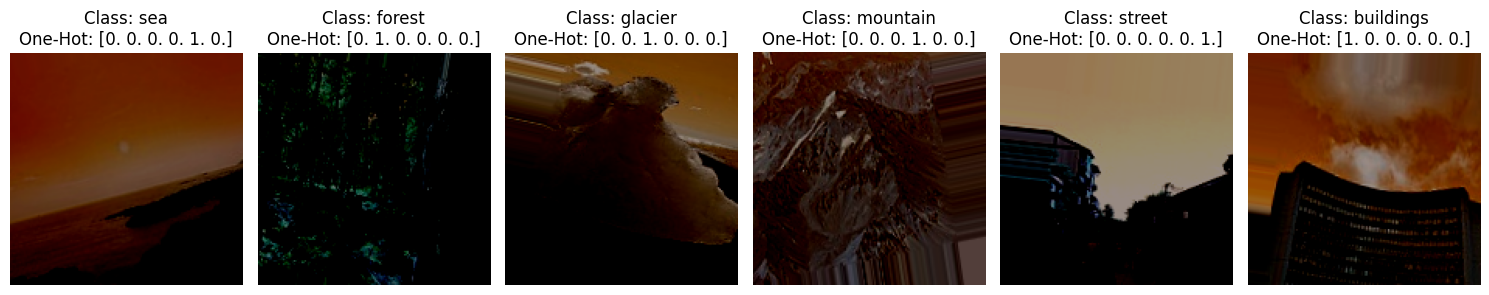

Test data after resizing and preprocessing


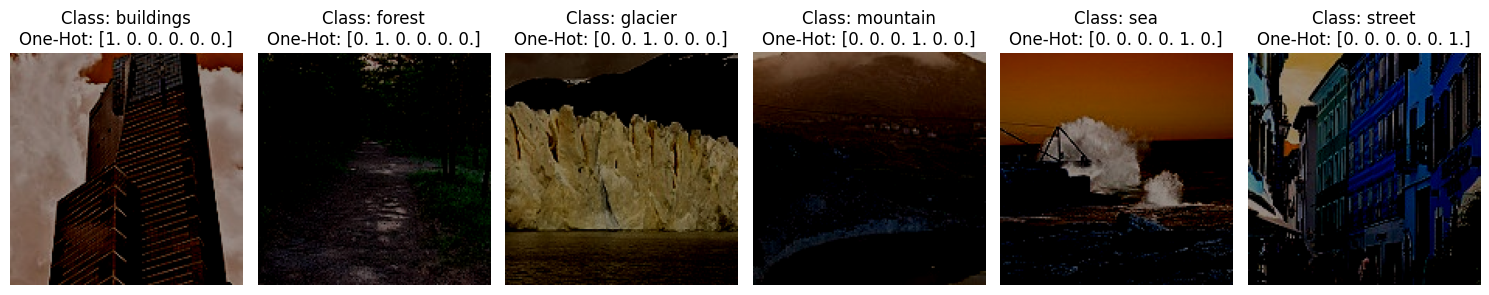

In [7]:
train_data,train_eval, val_data, test_data, metadata = create_augmented_data_generators(train_dir=TRAIN_DIR,test_dir=TEST_DIR,img_size=IMG_SIZE,batch_size=BATCH_SIZE
,model_type="ResNet50")

In [12]:
def resnet50(train_data, val_data, test_data, img_size, num_classes, learning_rate=0.001, epochs=EPOCHS, batch_size=BATCH_SIZE, dropout_rate=0.2, checkpoint_path='best_model.keras'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=img_size + (3,), pooling='avg')
    base_model.trainable = False

    inputs = base_model.input
    x = base_model.output
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform', bias_initializer='zeros')(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)

    model = Model(inputs, outputs)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min'),
        ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-4, verbose=1, mode='min'),
        ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]

    model.compile(optimizer=Adam(learning_rate=learning_rate, epsilon=1e-4, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Training the last fully connected layer...")

    history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callbacks, batch_size=batch_size)

    print("\nPlotting Training Curves...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

    model.load_weights(checkpoint_path)

    return model, history


Training the last fully connected layer...
Epoch 1/70


I0000 00:00:1734331937.529844  277132 service.cc:148] XLA service 0x7f56f8003390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734331937.530023  277132 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-12-15 22:52:17.867556: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734331938.956193  277132 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/351 ━━━━━━━━━━━━━━━━━━━━ 1:17:22 13s/step - accuracy: 0.0625 - loss: 3.2368

I0000 00:00:1734331944.681534  277132 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.7580 - loss: 0.8980
Epoch 1: val_accuracy improved from -inf to 0.88980, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 143s 371ms/step - accuracy: 0.7582 - loss: 0.8973 - val_accuracy: 0.8898 - val_loss: 0.4769 - learning_rate: 0.0010
Epoch 2/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.8745 - loss: 0.4970
Epoch 2: val_accuracy improved from 0.88980 to 0.90514, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 112s 320ms/step - accuracy: 0.8745 - loss: 0.4970 - val_accuracy: 0.9051 - val_loss: 0.4175 - learning_rate: 0.0010
Epoch 3/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.8918 - loss: 0.4355
Epoch 3: val_accuracy did not improve from 0.90514
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 311ms/step - accuracy: 0.8918 - loss: 0.4356 - val_accuracy: 0.8959 - val_loss: 0.4254 - learning_rate: 0.0010
Epoch 4/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9042 - loss: 0.400

351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 298ms/step - accuracy: 0.9290 - loss: 0.2851 - val_accuracy: 0.9112 - val_loss: 0.3599 - learning_rate: 5.0000e-04
Epoch 24/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9267 - loss: 0.2855
Epoch 24: val_accuracy improved from 0.91369 to 0.91904, saving model to best_model.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 104s 296ms/step - accuracy: 0.9267 - loss: 0.2854 - val_accuracy: 0.9190 - val_loss: 0.3293 - learning_rate: 5.0000e-04
Epoch 25/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9306 - loss: 0.2677
Epoch 25: val_accuracy did not improve from 0.91904
351/351 ━━━━━━━━━━━━━━━━━━━━ 103s 295ms/step - accuracy: 0.9306 - loss: 0.2677 - val_accuracy: 0.9155 - val_loss: 0.3302 - learning_rate: 5.0000e-04
Epoch 26/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9313 - loss: 0.2651
Epoch 26: val_accuracy did not improve from 0.91904
351/351 ━━━━━━━━━━━━━━━━━━━━ 104s 297ms/step - accuracy: 0.9313 - loss: 0.2651 - val_accurac

351/351 ━━━━━━━━━━━━━━━━━━━━ 103s 292ms/step - accuracy: 0.9481 - loss: 0.1948 - val_accuracy: 0.9201 - val_loss: 0.3239 - learning_rate: 1.2500e-04
Epoch 46/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9552 - loss: 0.1799
Epoch 46: val_accuracy did not improve from 0.92974
351/351 ━━━━━━━━━━━━━━━━━━━━ 103s 293ms/step - accuracy: 0.9552 - loss: 0.1799 - val_accuracy: 0.9180 - val_loss: 0.3133 - learning_rate: 1.0000e-04
Epoch 47/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9545 - loss: 0.1813
Epoch 47: val_accuracy did not improve from 0.92974
351/351 ━━━━━━━━━━━━━━━━━━━━ 103s 293ms/step - accuracy: 0.9545 - loss: 0.1813 - val_accuracy: 0.9151 - val_loss: 0.3030 - learning_rate: 1.0000e-04
Epoch 48/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.9512 - loss: 0.1891
Epoch 48: val_accuracy did not improve from 0.92974
351/351 ━━━━━━━━━━━━━━━━━━━━ 102s 291ms/step - accuracy: 0.9512 - loss: 0.1891 - val_accuracy: 0.9148 - val_loss: 0.3174 - learnin

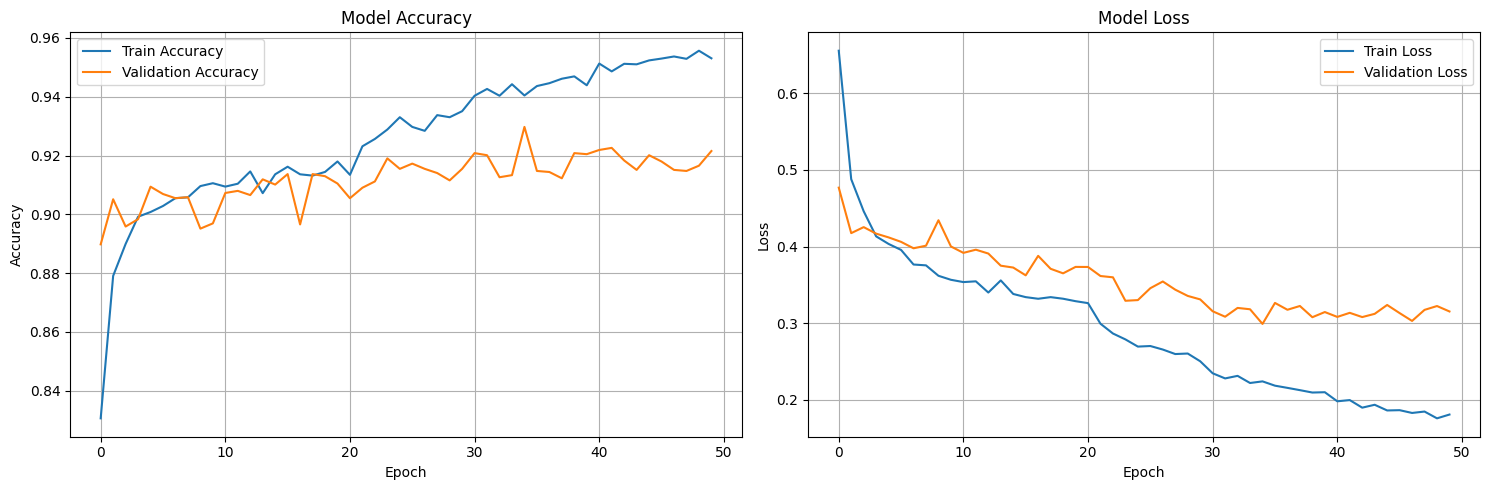

In [13]:
resnet50_model, history_resnet50 = resnet50(train_data,val_data,test_data,img_size=IMG_SIZE,num_classes=6,learning_rate=0.001)

In [14]:
results = {}

In [15]:
def evaluate_model(data, model, dataset_name):
    print(f"\nEvaluating {dataset_name}...")
    y_true = data.classes
    steps = int(np.ceil(data.samples / data.batch_size))
    y_pred_probs = model.predict(data, steps=steps, verbose=1)
    y_pred = np.argmax(y_pred_probs, axis=1)
    print(f"\nClassification Report for {dataset_name} Data:")
    print(classification_report(y_true, y_pred, target_names=list(data.class_indices.keys())))
    y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=len(data.class_indices))
    auc = roc_auc_score(y_true_one_hot, y_pred_probs, multi_class="ovr")
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")

    print(f"{dataset_name} Metrics:")
    print(f"  AUC: {auc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(data.class_indices.keys()), yticklabels=list(data.class_indices.keys()))
    plt.title(f'Confusion Matrix for {dataset_name} Data')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.tight_layout()
    plt.show()

    return {"AUC": auc, "Precision": precision, "Recall": recall, "F1-Score": f1, "Confusion Matrix": cm}


Evaluating Train...


2024-12-16 00:21:44.726816: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1937', 8 bytes spill stores, 8 bytes spill loads



438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

2024-12-16 00:22:43.562791: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1922', 40 bytes spill stores, 40 bytes spill loads

2024-12-16 00:22:43.934835: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1922_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-16 00:22:43.937884: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1922', 228 bytes spill stores, 276 bytes spill loads

2024-12-16 00:22:43.980195: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1937', 8 bytes spill stores, 8 bytes spill loads



439/439 ━━━━━━━━━━━━━━━━━━━━ 66s 139ms/step

Classification Report for Train Data:
              precision    recall  f1-score   support

   buildings       0.97      0.94      0.95      2191
      forest       0.99      0.99      0.99      2271
     glacier       0.91      0.92      0.92      2404
    mountain       0.93      0.91      0.92      2512
         sea       0.98      0.98      0.98      2274
      street       0.94      0.98      0.96      2382

    accuracy                           0.95     14034
   macro avg       0.95      0.95      0.95     14034
weighted avg       0.95      0.95      0.95     14034

Train Metrics:
  AUC: 0.9965
  Precision: 0.9526
  Recall: 0.9525
  F1-Score: 0.9525


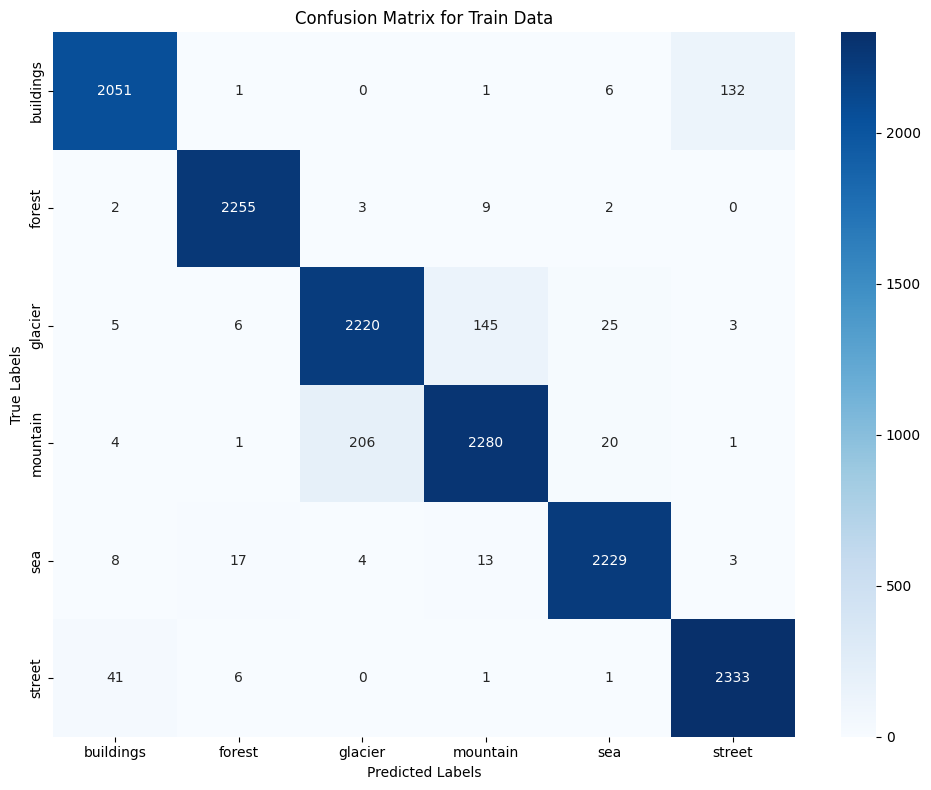


Evaluating Validation...
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step

2024-12-16 00:23:08.881860: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1922', 40 bytes spill stores, 40 bytes spill loads

2024-12-16 00:23:09.160736: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1922_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-16 00:23:09.445756: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1937', 8 bytes spill stores, 8 bytes spill loads

2024-12-16 00:23:09.603586: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1922', 228 bytes spill stores, 276 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 258ms/step

Classification Report for Validation Data:
              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       438
      forest       0.98      0.98      0.98       454
     glacier       0.88      0.85      0.86       480
    mountain       0.86      0.88      0.87       502
         sea       0.92      0.94      0.93       454
      street       0.92      0.94      0.93       476

    accuracy                           0.91      2804
   macro avg       0.91      0.91      0.91      2804
weighted avg       0.91      0.91      0.91      2804

Validation Metrics:
  AUC: 0.9915
  Precision: 0.9137
  Recall: 0.9137
  F1-Score: 0.9136


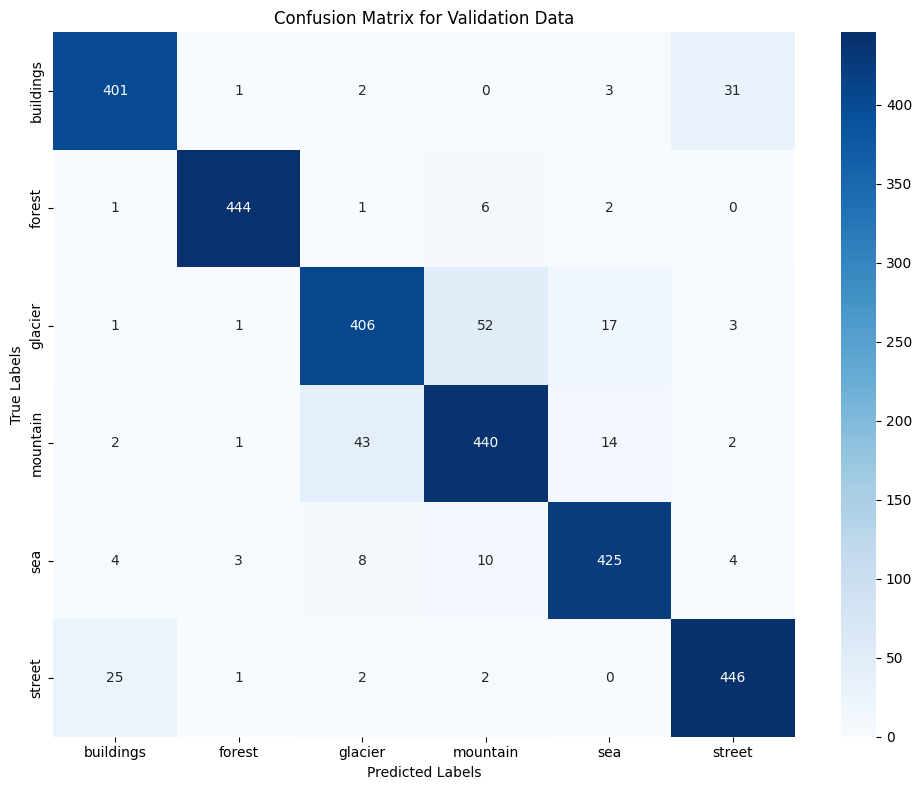


Evaluating Test...
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step

2024-12-16 00:23:28.444862: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1922', 40 bytes spill stores, 40 bytes spill loads

2024-12-16 00:23:28.821573: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1922', 228 bytes spill stores, 276 bytes spill loads

2024-12-16 00:23:29.177937: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1922_0', 8 bytes spill stores, 8 bytes spill loads

2024-12-16 00:23:29.238840: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1937', 8 bytes spill stores, 8 bytes spill loads



94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 220ms/step

Classification Report for Test Data:
              precision    recall  f1-score   support

   buildings       0.95      0.90      0.92       437
      forest       0.98      0.99      0.98       474
     glacier       0.87      0.88      0.87       553
    mountain       0.90      0.85      0.87       525
         sea       0.95      0.97      0.96       510
      street       0.91      0.97      0.94       501

    accuracy                           0.92      3000
   macro avg       0.93      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000

Test Metrics:
  AUC: 0.9926
  Precision: 0.9228
  Recall: 0.9227
  F1-Score: 0.9223


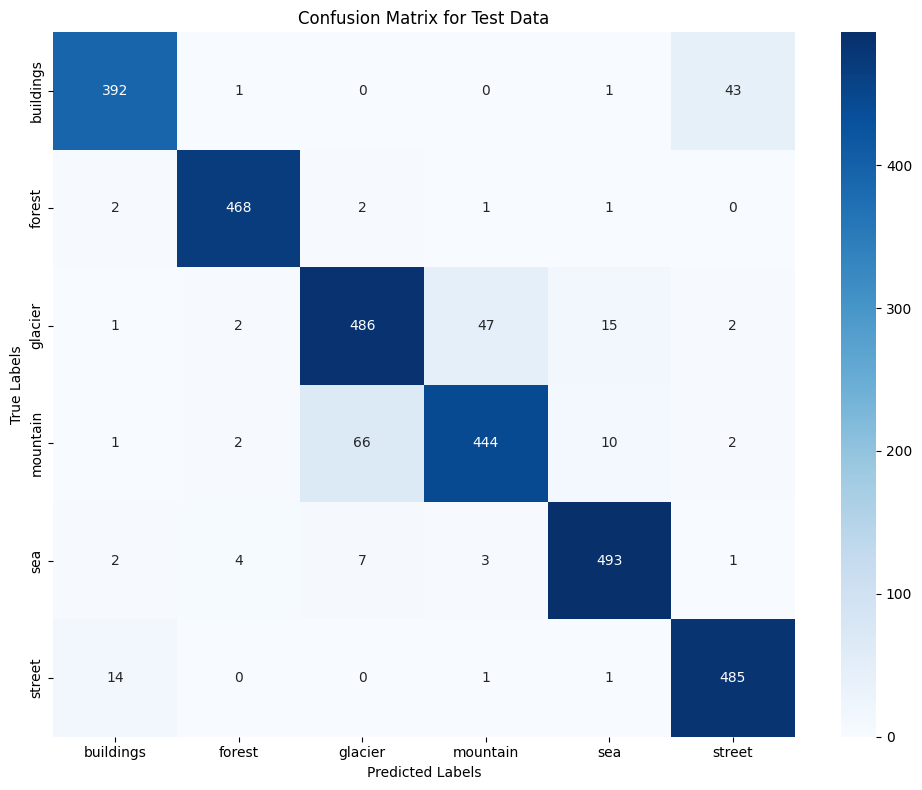

In [16]:
resnet50_train = evaluate_model(train_eval, resnet50_model, "Train")
resnet50_val = evaluate_model(val_data, resnet50_model, "Validation")
resnet50_test = evaluate_model(test_data, resnet50_model, "Test")
results["ResNet50"] = resnet50_test

In [17]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_random_images(model, test_dir, img_size, class_indices, num_images=6):
    
    class_labels = {v: k for k, v in class_indices.items()}
    image_paths = []
    for class_dir in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_dir)
        if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                if img.endswith('.jpg'):
                    image_paths.append((os.path.join(class_path, img), class_dir))
    
    random_images = random.sample(image_paths, min(num_images, len(image_paths)))
    
    fig = plt.figure(figsize=(25, 20))
    plt.subplots_adjust(hspace=0.4)
    
    for i, (img_path, true_class) in enumerate(random_images):
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array_expanded = np.expand_dims(img_array, axis=0)
        
        predictions = model.predict(img_array_expanded, verbose=0)
        top_indices = np.argsort(predictions[0])[-3:][::-1]
        top_classes = [class_labels[idx] for idx in top_indices]
        top_confidences = [predictions[0][idx] * 100 for idx in top_indices]
        
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis('off')
        
        title = f"True Class: {true_class.upper()}\n\n"
        title += f"Predictions:\n"
        for j, (cls, conf) in enumerate(zip(top_classes, top_confidences)):
            title += f"{j+1}. {cls.upper()}: {conf:.1f}%\n"
        
        plt.title(title, bbox=dict(facecolor='white', alpha=0.8),color='darkblue' if top_classes[0] == true_class else 'darkred',
                 fontsize=12,
                 pad=15)
    return random_images

[('..//dataset/seg_test/forest/20638.jpg', 'forest'),
 ('..//dataset/seg_test/mountain/24287.jpg', 'mountain'),
 ('..//dataset/seg_test/forest/20288.jpg', 'forest'),
 ('..//dataset/seg_test/forest/21046.jpg', 'forest'),
 ('..//dataset/seg_test/forest/23371.jpg', 'forest')]

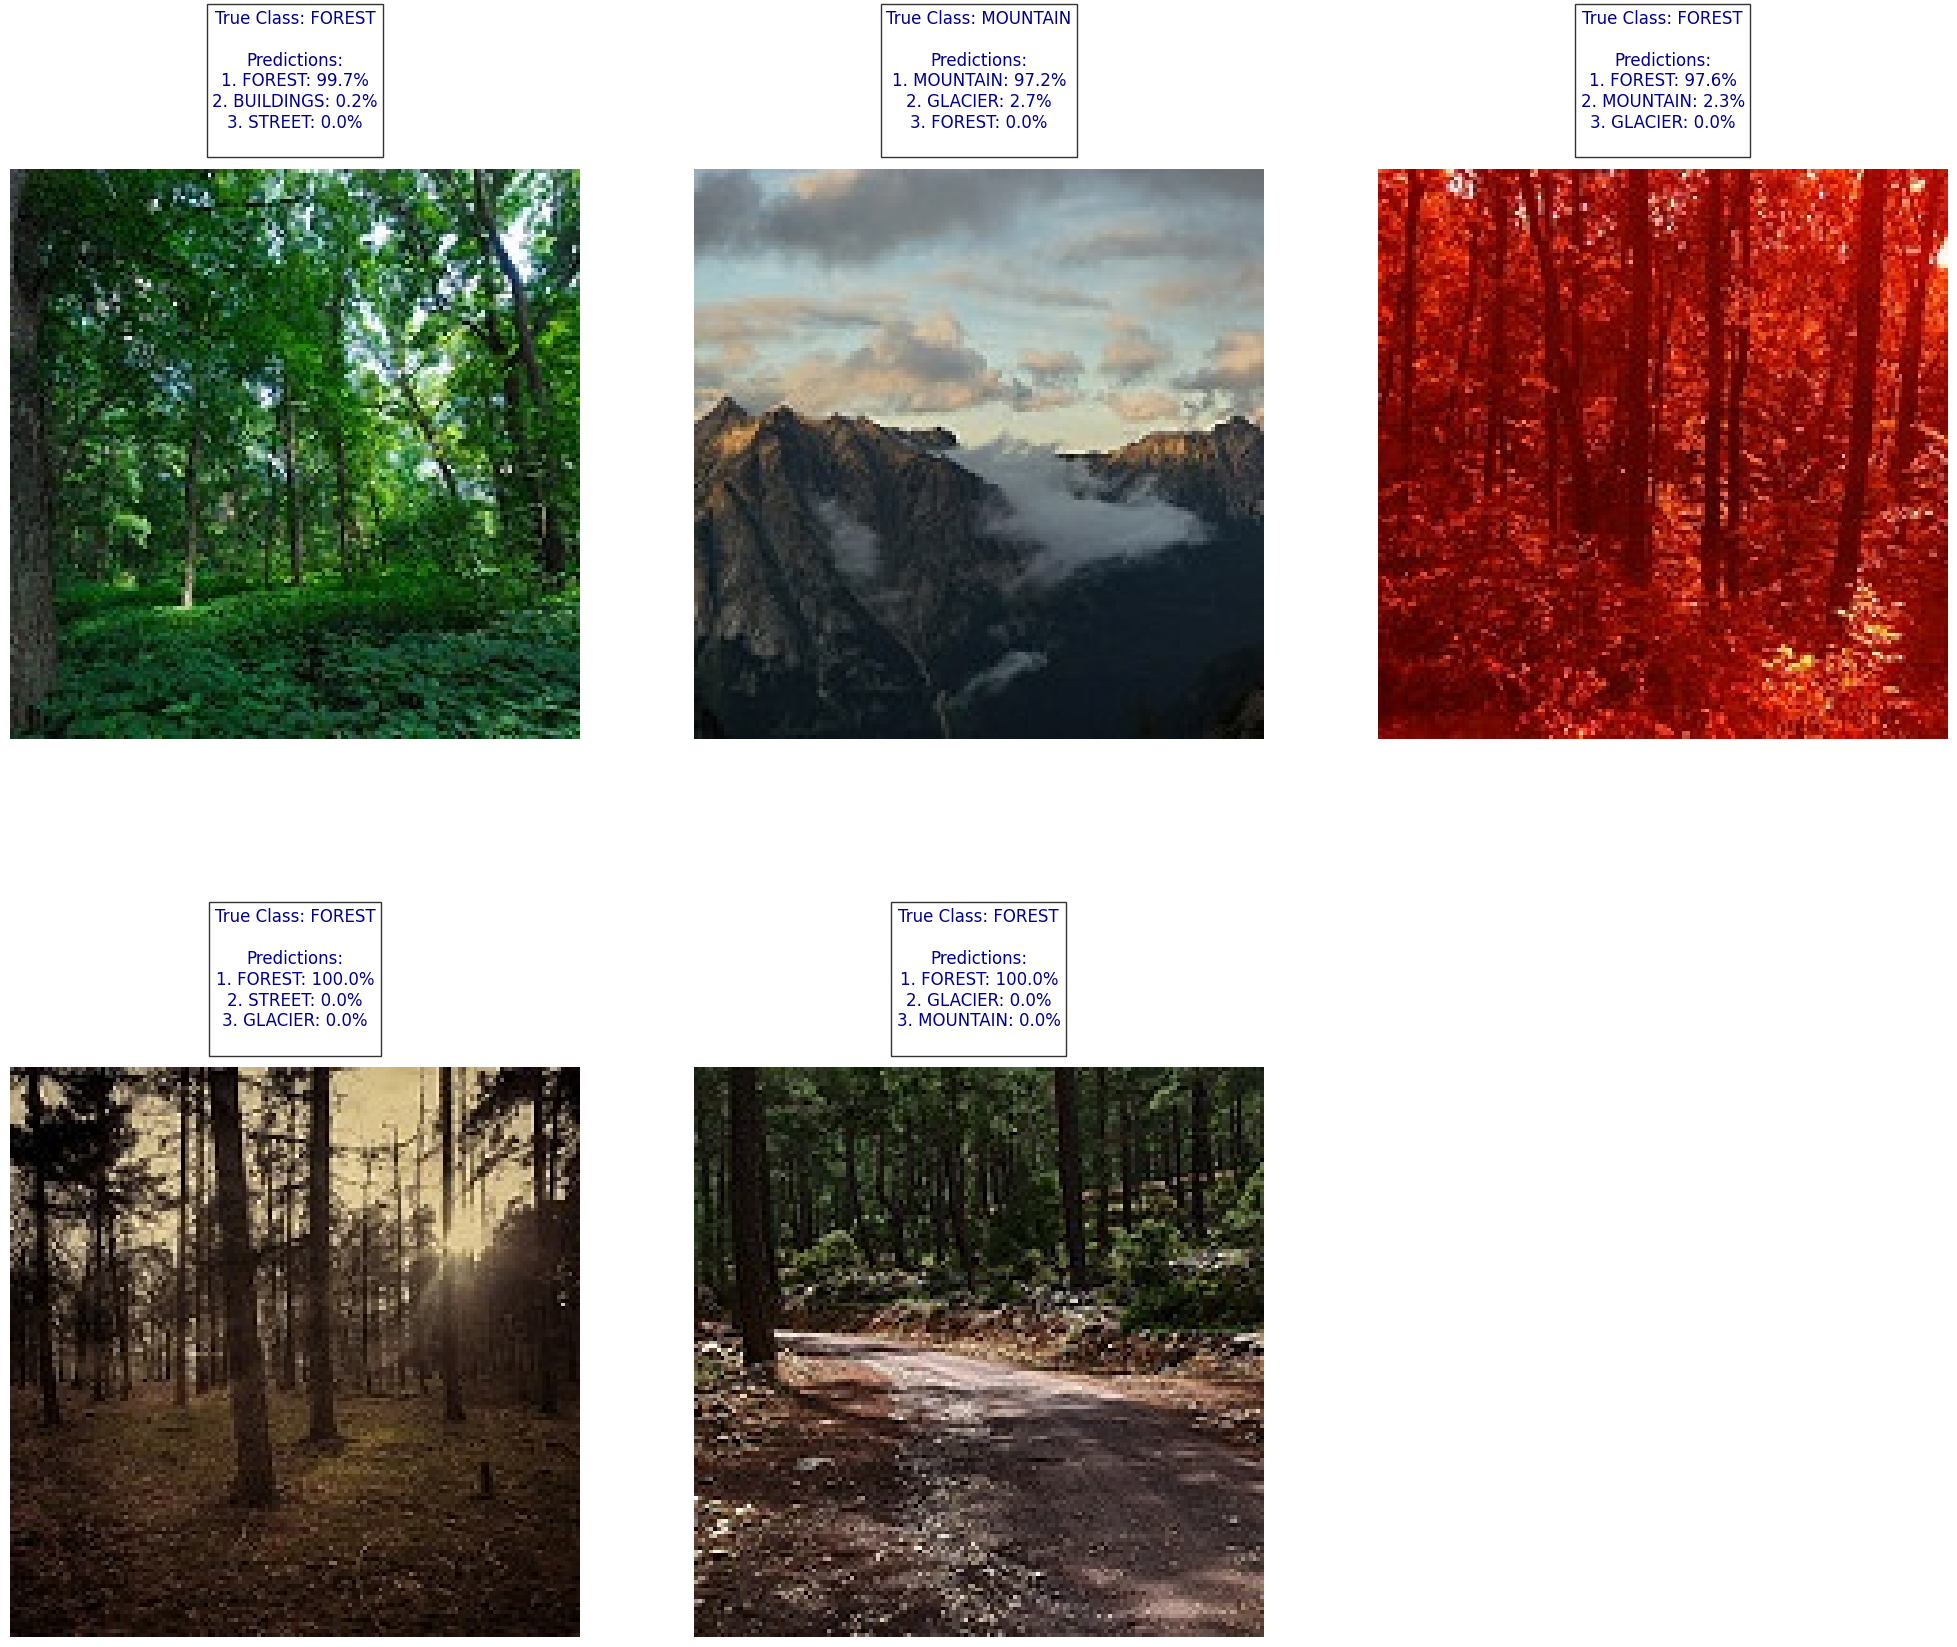

In [18]:
predict_random_images(model=resnet50_model, test_dir=TEST_DIR, img_size=IMG_SIZE, class_indices=metadata['class_indices'], num_images=5)

In [19]:
clear_session()

<h3>ResNet101</h3>

Found 14034 images belonging to 6 classes.
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Data prepared for ResNet101
Train data after image augmentation and preprocessing


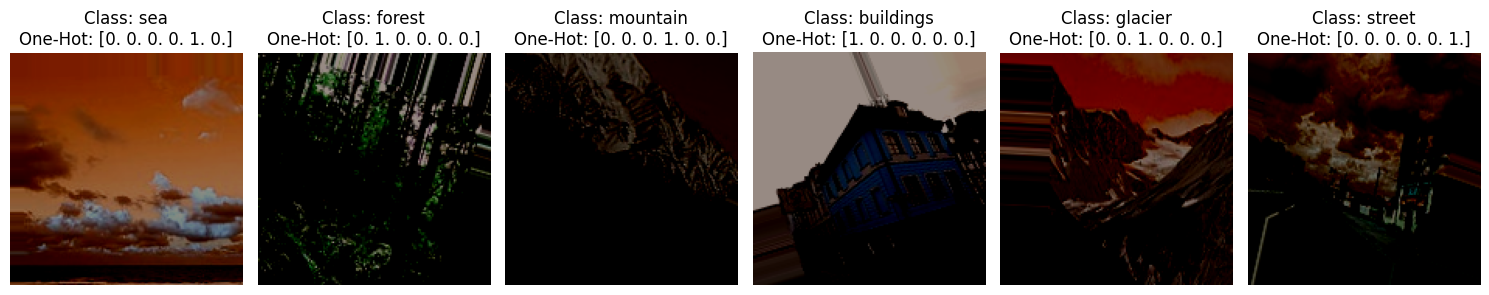

Test data after resizing and preprocessing


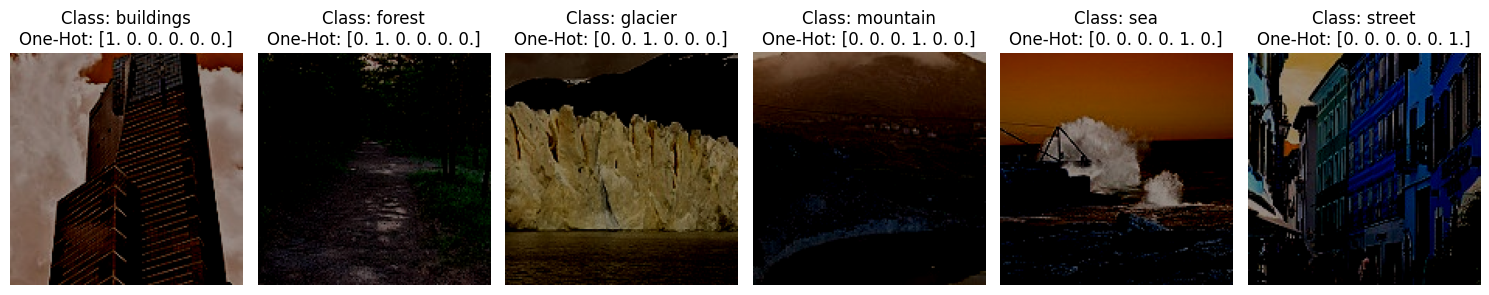

In [20]:
train_data,train_eval, val_data, test_data, metadata= create_augmented_data_generators(train_dir=TRAIN_DIR,test_dir=TEST_DIR,img_size=IMG_SIZE,batch_size=BATCH_SIZE
,model_type="ResNet101")

In [21]:
def resnet101(train_data, val_data, test_data, img_size, num_classes, learning_rate=0.001, epochs=EPOCHS, batch_size=BATCH_SIZE, dropout_rate=0.2, checkpoint_path='resnet101_best.keras'):
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=img_size + (3,), pooling='avg')
    base_model.trainable = False

    inputs = base_model.input
    x = base_model.output
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform', bias_initializer='zeros')(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.0001))(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)

    model = Model(inputs, outputs)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min'),
        ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-4, verbose=1, mode='min'),
        ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]

    model.compile(optimizer=Adam(learning_rate=learning_rate, epsilon=1e-7, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Training the last fully connected layer...")

    history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callbacks, batch_size=batch_size)

    print("\nPlotting Training Curves...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

    model.load_weights(checkpoint_path)

    return model, history

Training the last fully connected layer...
Epoch 1/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.7678 - loss: 0.8513
Epoch 1: val_accuracy improved from -inf to 0.88552, saving model to resnet101_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 137s 349ms/step - accuracy: 0.7680 - loss: 0.8506 - val_accuracy: 0.8855 - val_loss: 0.4820 - learning_rate: 0.0010
Epoch 2/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.8764 - loss: 0.4903
Epoch 2: val_accuracy improved from 0.88552 to 0.91120, saving model to resnet101_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 309ms/step - accuracy: 0.8764 - loss: 0.4903 - val_accuracy: 0.9112 - val_loss: 0.4152 - learning_rate: 0.0010
Epoch 3/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.8939 - loss: 0.4301
Epoch 3: val_accuracy did not improve from 0.91120
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 309ms/step - accuracy: 0.8939 - loss: 0.4301 - val_accuracy: 0.9073 - val_loss: 0.4130 - learning_rate: 0.0010
Epoch 4/70
351/351 ━━━━━

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9263 - loss: 0.2776
Epoch 23: val_accuracy did not improve from 0.91976
351/351 ━━━━━━━━━━━━━━━━━━━━ 110s 312ms/step - accuracy: 0.9263 - loss: 0.2776 - val_accuracy: 0.9183 - val_loss: 0.3470 - learning_rate: 5.0000e-04
Epoch 24/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9315 - loss: 0.2609
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 24: val_accuracy did not improve from 0.91976
351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 299ms/step - accuracy: 0.9315 - loss: 0.2609 - val_accuracy: 0.9058 - val_loss: 0.3383 - learning_rate: 5.0000e-04
Epoch 25/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9321 - loss: 0.2613
Epoch 25: val_accuracy did not improve from 0.91976
351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 299ms/step - accuracy: 0.9321 - loss: 0.2613 - val_accuracy: 0.9158 - val_loss: 0.3315 - learning_rate: 2.5000e-04
Epoch 26/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accurac

Epoch 45/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.9560 - loss: 0.1799
Epoch 45: val_accuracy did not improve from 0.92511
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 309ms/step - accuracy: 0.9560 - loss: 0.1799 - val_accuracy: 0.9165 - val_loss: 0.3251 - learning_rate: 1.0000e-04
Epoch 46/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9489 - loss: 0.1943
Epoch 46: val_accuracy did not improve from 0.92511
351/351 ━━━━━━━━━━━━━━━━━━━━ 108s 308ms/step - accuracy: 0.9489 - loss: 0.1943 - val_accuracy: 0.9240 - val_loss: 0.3041 - learning_rate: 1.0000e-04
Epoch 47/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9580 - loss: 0.1744
Epoch 47: val_accuracy did not improve from 0.92511
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 302ms/step - accuracy: 0.9579 - loss: 0.1744 - val_accuracy: 0.9187 - val_loss: 0.3209 - learning_rate: 1.0000e-04

Plotting Training Curves...


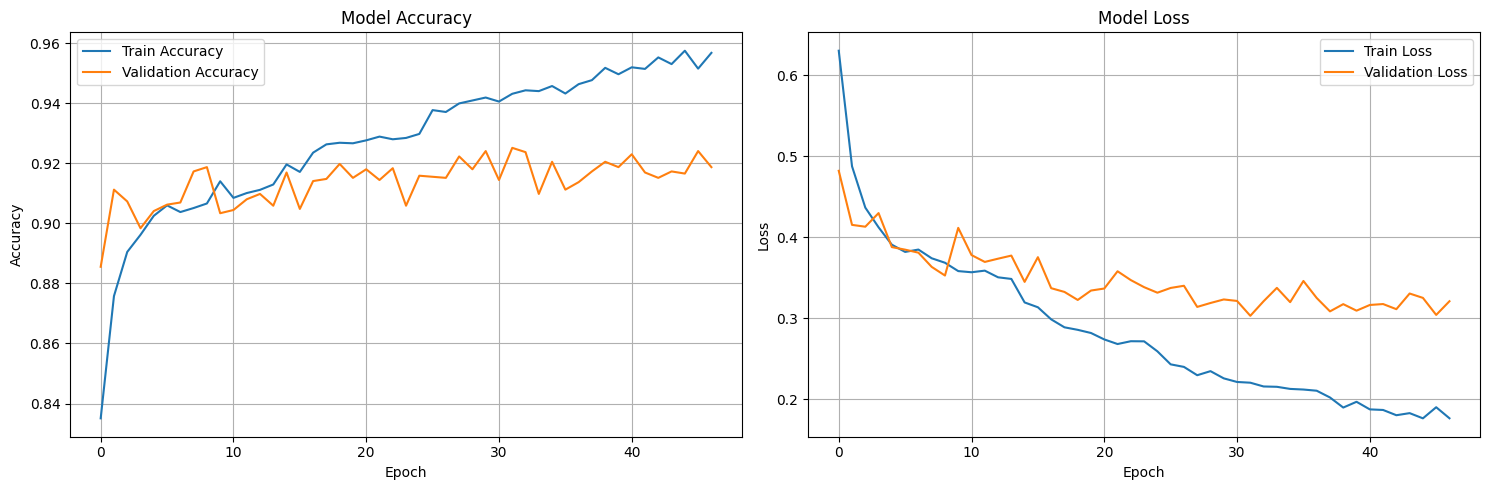

In [22]:
resnet101_model, history_resnet101 = resnet101(train_data,val_data,test_data,img_size=IMG_SIZE,num_classes=6)


Evaluating Train...
439/439 ━━━━━━━━━━━━━━━━━━━━ 68s 142ms/step

Classification Report for Train Data:
              precision    recall  f1-score   support

   buildings       0.95      0.97      0.96      2191
      forest       0.99      0.99      0.99      2271
     glacier       0.89      0.94      0.91      2404
    mountain       0.91      0.89      0.90      2512
         sea       0.99      0.95      0.97      2274
      street       0.97      0.95      0.96      2382

    accuracy                           0.95     14034
   macro avg       0.95      0.95      0.95     14034
weighted avg       0.95      0.95      0.95     14034

Train Metrics:
  AUC: 0.9955
  Precision: 0.9477
  Recall: 0.9469
  F1-Score: 0.9470


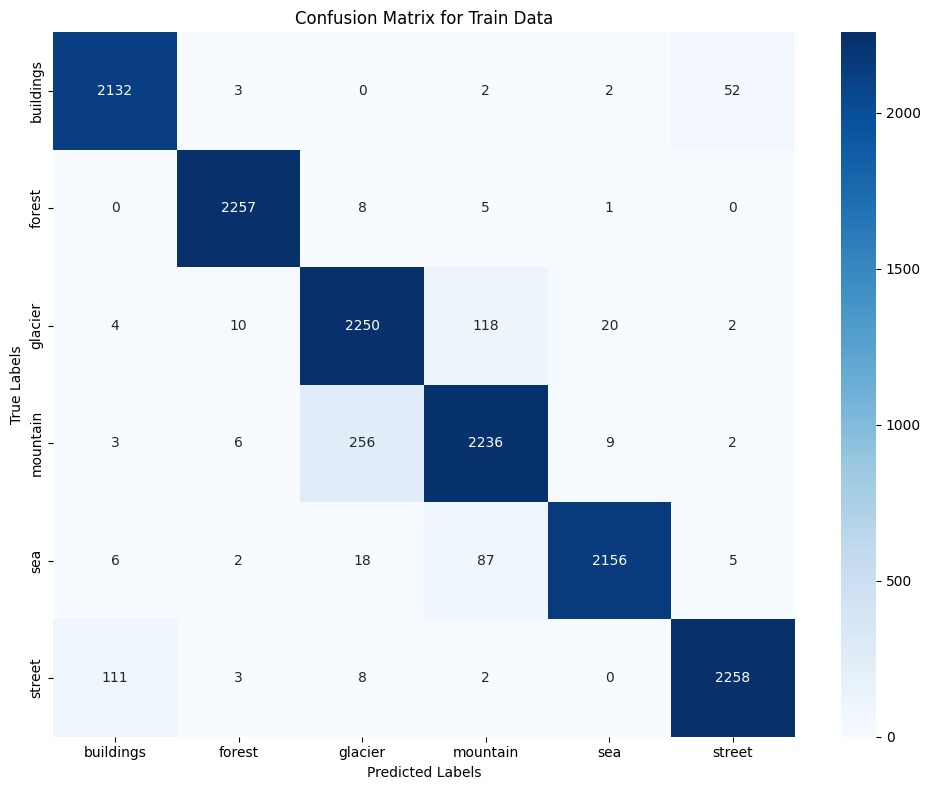


Evaluating Validation...
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 265ms/step

Classification Report for Validation Data:
              precision    recall  f1-score   support

   buildings       0.94      0.93      0.93       438
      forest       0.99      0.98      0.99       454
     glacier       0.87      0.85      0.86       480
    mountain       0.87      0.87      0.87       502
         sea       0.94      0.97      0.95       454
      street       0.93      0.95      0.94       476

    accuracy                           0.92      2804
   macro avg       0.92      0.92      0.92      2804
weighted avg       0.92      0.92      0.92      2804

Validation Metrics:
  AUC: 0.9921
  Precision: 0.9223
  Recall: 0.9226
  F1-Score: 0.9224


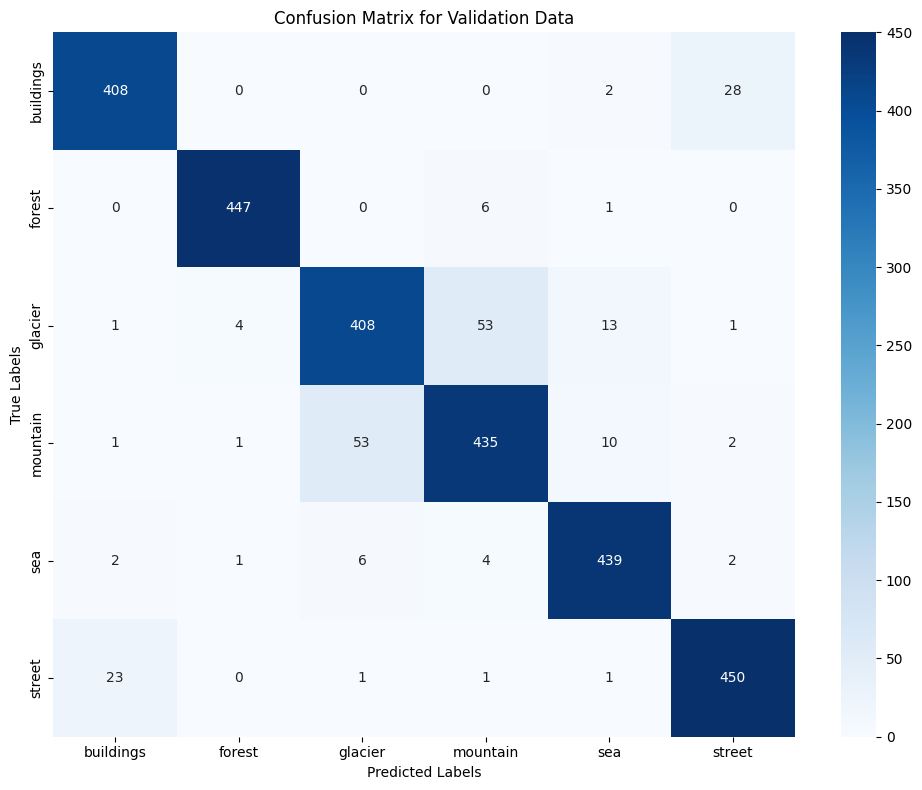


Evaluating Test...
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 157ms/step

Classification Report for Test Data:
              precision    recall  f1-score   support

   buildings       0.90      0.95      0.92       437
      forest       0.98      0.99      0.99       474
     glacier       0.88      0.90      0.89       553
    mountain       0.87      0.86      0.87       525
         sea       0.96      0.92      0.94       510
      street       0.95      0.92      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000

Test Metrics:
  AUC: 0.9920
  Precision: 0.9222
  Recall: 0.9217
  F1-Score: 0.9217


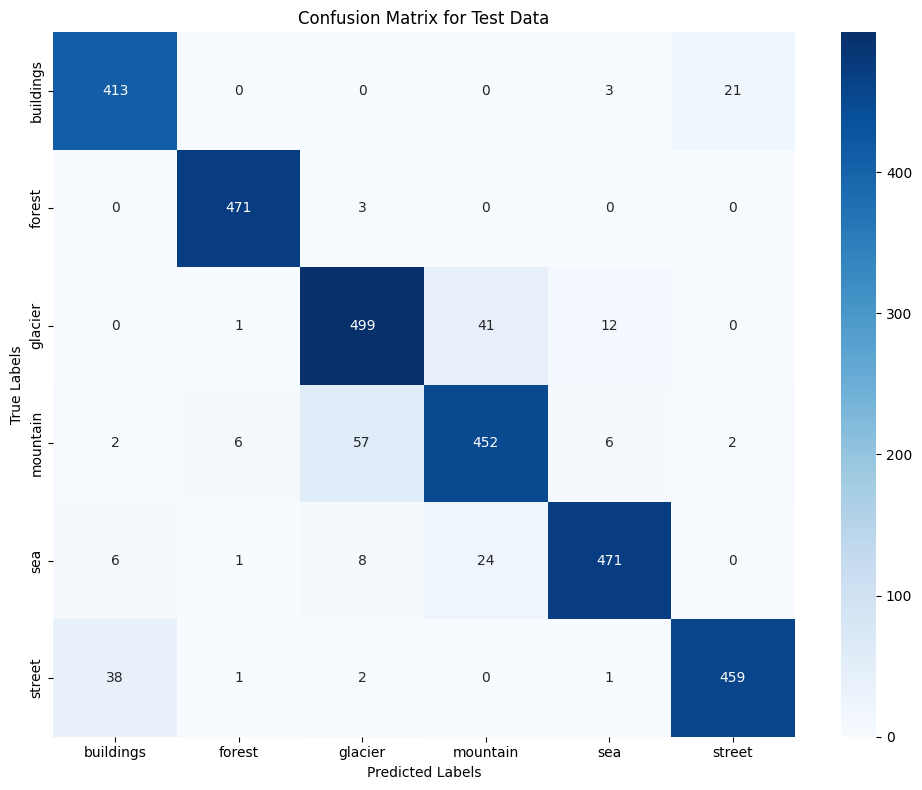

In [23]:
resnet101_train = evaluate_model(train_eval, resnet101_model, "Train")
resnet101_val = evaluate_model(val_data, resnet101_model, "Validation")
resnet101_test = evaluate_model(test_data, resnet101_model, "Test")
results["ResNet101"] = resnet101_test

[('..//dataset/seg_test/sea/21037.jpg', 'sea'),
 ('..//dataset/seg_test/mountain/21340.jpg', 'mountain'),
 ('..//dataset/seg_test/sea/21730.jpg', 'sea'),
 ('..//dataset/seg_test/sea/20946.jpg', 'sea'),
 ('..//dataset/seg_test/mountain/23126.jpg', 'mountain')]

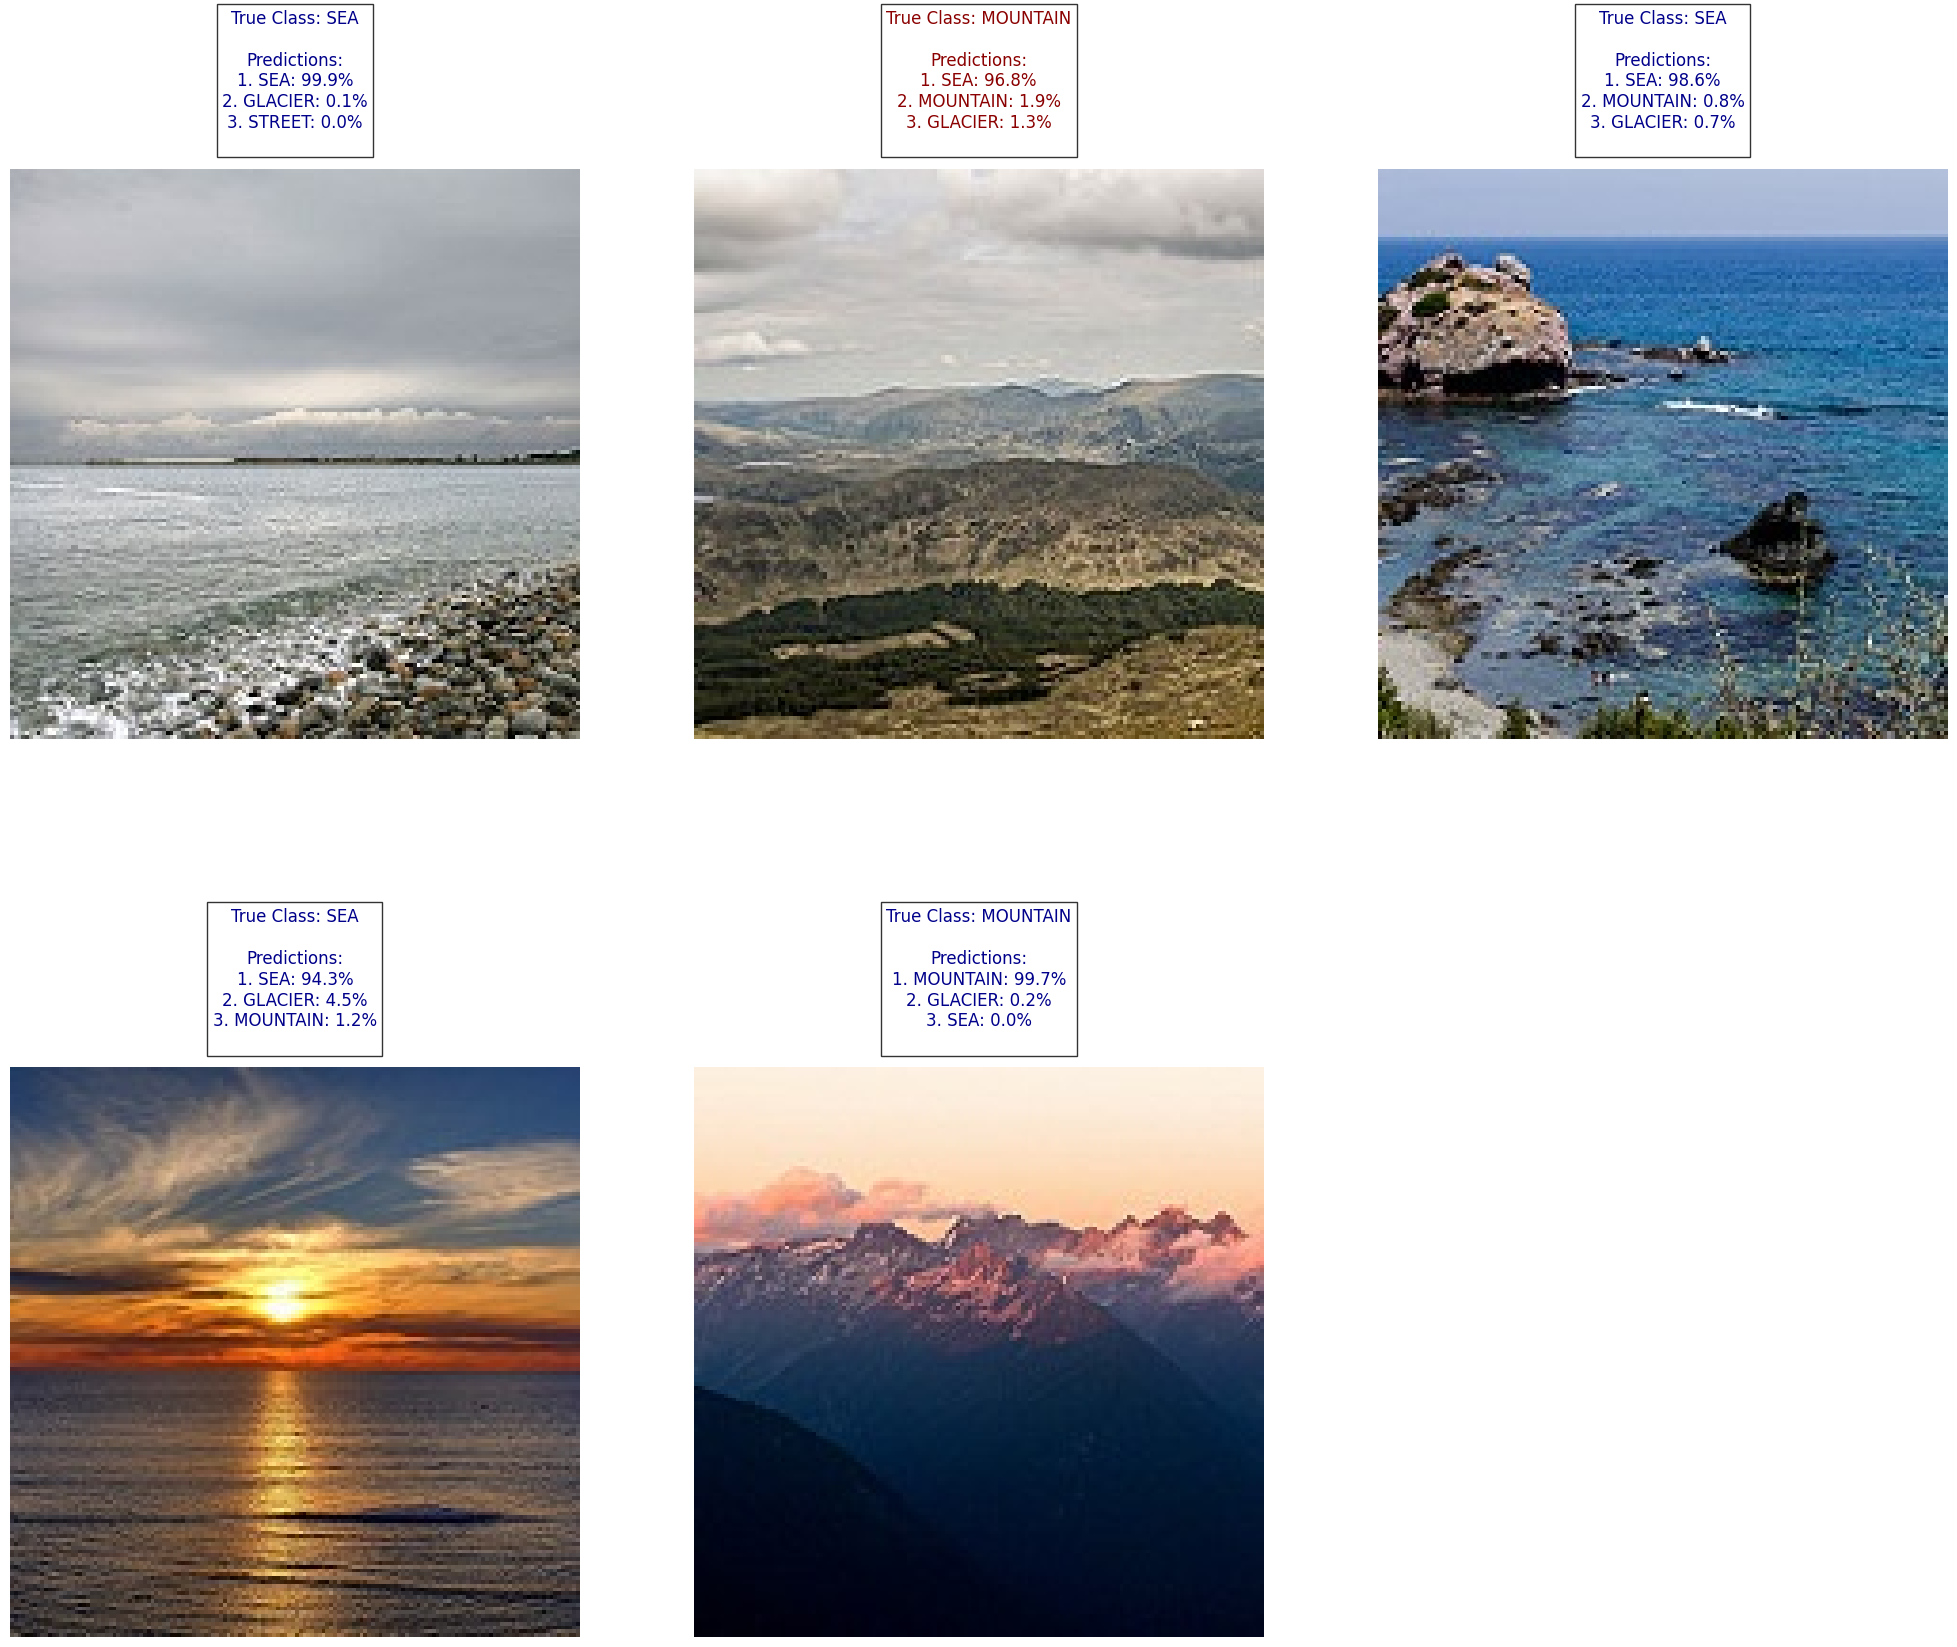

In [24]:
predict_random_images(model=resnet101_model,test_dir=TEST_DIR,img_size=IMG_SIZE,class_indices=metadata['class_indices'],num_images=5)

In [25]:
clear_session()

<h3>EfficientNetB0</h3>

Found 14034 images belonging to 6 classes.
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Data prepared for EfficientNetB0
Train data after image augmentation and preprocessing


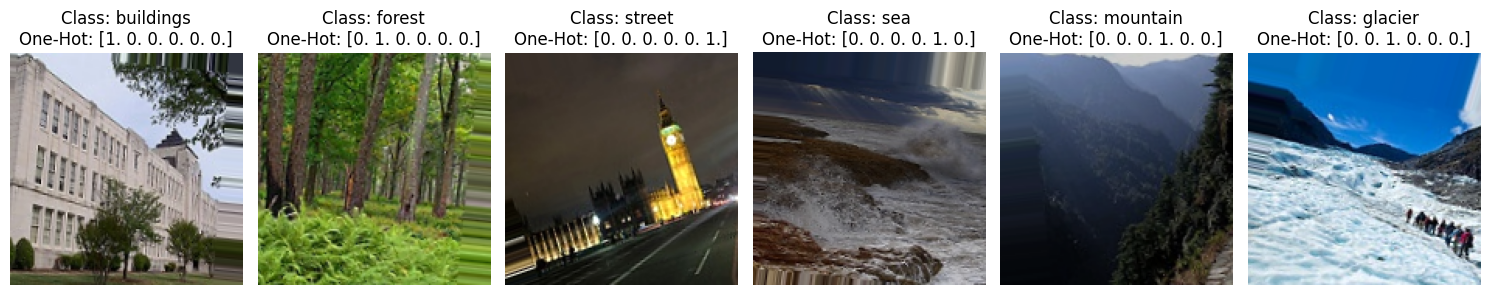

Test data after resizing and preprocessing


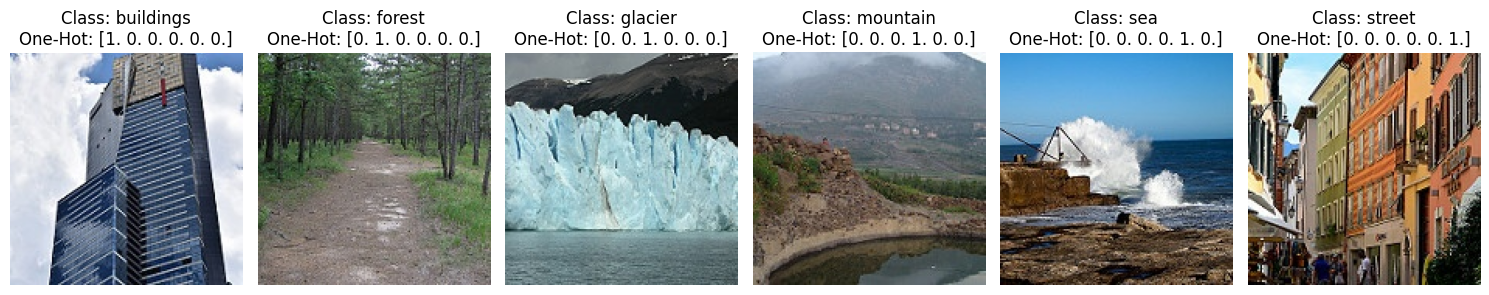

In [26]:
train_data,train_eval, val_data, test_data, metadata = create_augmented_data_generators(train_dir=TRAIN_DIR,test_dir=TEST_DIR,img_size=IMG_SIZE,batch_size=BATCH_SIZE
,model_type="EfficientNetB0")

In [27]:
def efficientnet(train_data, val_data, test_data, img_size, num_classes,learning_rate=0.0001,epochs=EPOCHS, batch_size=BATCH_SIZE, dropout_rate=0.2, checkpoint_path='efficientnet_best.keras'):
    
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=img_size + (3,), pooling='avg')
    base_model.trainable = False
    
    inputs = base_model.input
    x = base_model.output
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform', bias_initializer='zeros')(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-5)(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)

    model = Model(inputs, outputs)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min'),
        ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-4, verbose=1, mode='min'),
        ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]

    model.compile(optimizer=Adam(learning_rate=learning_rate, epsilon=1e-7, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Training the last fully connected layer...")

    history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callbacks, batch_size=batch_size)

    print("\nPlotting Training Curves...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

    model.load_weights(checkpoint_path)

    return model, history

Training the last fully connected layer...
Epoch 1/70


E0000 00:00:1734342688.977531  277133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734342689.172566  277133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734342689.399888  277133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734342689.600833  277133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734342690.466551  277133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

324/351 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.6542 - loss: 1.1364

2024-12-16 01:53:03.278450: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=0} for conv (f16[30,10,10,480]{3,2,1,0}, u8[0]{0}) custom-call(f16[30,10,10,480]{3,2,1,0}, f16[480,5,5,1]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, feature_group_count=480, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2024-12-16 01:53:03.416237: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.162428726s
Trying algorithm eng3{k11=0} for conv (f16[30,10,10,480]{3,2,1,0}, u8[0]{0}) custom-call(f16[30,10,10,480]{3,2,1,0}, f16[480,5,5,1]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=b01f_o01i->b01f, feature_group_count=480, custom_call_target="__cudnn$convForward", backend

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.6639 - loss: 1.1056

E0000 00:00:1734342830.131772  277130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734342830.335115  277130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734342831.163082  277130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734342831.393257  277130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.



Epoch 1: val_accuracy improved from -inf to 0.88481, saving model to efficientnet_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 161s 394ms/step - accuracy: 0.6642 - loss: 1.1045 - val_accuracy: 0.8848 - val_loss: 0.4376 - learning_rate: 1.0000e-04
Epoch 2/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.8703 - loss: 0.4570
Epoch 2: val_accuracy improved from 0.88481 to 0.89765, saving model to efficientnet_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 302ms/step - accuracy: 0.8703 - loss: 0.4571 - val_accuracy: 0.8976 - val_loss: 0.4004 - learning_rate: 1.0000e-04
Epoch 3/70
348/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.8789 - loss: 0.4312
Epoch 3: val_accuracy did not improve from 0.89765
351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 299ms/step - accuracy: 0.8789 - loss: 0.4312 - val_accuracy: 0.8976 - val_loss: 0.3949 - learning_rate: 1.0000e-04
Epoch 4/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8881 - loss: 0.4087
Epoch 4: val_accuracy did not improve from 0.897

Epoch 24/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9292 - loss: 0.2725
Epoch 24: val_accuracy improved from 0.91512 to 0.91655, saving model to efficientnet_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 109s 310ms/step - accuracy: 0.9292 - loss: 0.2725 - val_accuracy: 0.9165 - val_loss: 0.3305 - learning_rate: 1.0000e-04
Epoch 25/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9323 - loss: 0.2815
Epoch 25: val_accuracy did not improve from 0.91655
351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 299ms/step - accuracy: 0.9322 - loss: 0.2816 - val_accuracy: 0.9123 - val_loss: 0.3262 - learning_rate: 1.0000e-04
Epoch 26/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9299 - loss: 0.2772
Epoch 26: val_accuracy did not improve from 0.91655
351/351 ━━━━━━━━━━━━━━━━━━━━ 106s 300ms/step - accuracy: 0.9299 - loss: 0.2772 - val_accuracy: 0.9162 - val_loss: 0.3306 - learning_rate: 1.0000e-04
Epoch 27/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9343 - loss: 0.2

351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 298ms/step - accuracy: 0.9454 - loss: 0.2190 - val_accuracy: 0.9119 - val_loss: 0.3359 - learning_rate: 1.0000e-04
Epoch 47/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9403 - loss: 0.2382
Epoch 47: val_accuracy did not improve from 0.92582
351/351 ━━━━━━━━━━━━━━━━━━━━ 101s 287ms/step - accuracy: 0.9403 - loss: 0.2382 - val_accuracy: 0.9151 - val_loss: 0.3326 - learning_rate: 1.0000e-04
Epoch 48/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9482 - loss: 0.2176
Epoch 48: val_accuracy did not improve from 0.92582
351/351 ━━━━━━━━━━━━━━━━━━━━ 102s 289ms/step - accuracy: 0.9482 - loss: 0.2177 - val_accuracy: 0.9126 - val_loss: 0.3436 - learning_rate: 1.0000e-04
Epoch 49/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.9460 - loss: 0.2255
Epoch 49: val_accuracy did not improve from 0.92582
351/351 ━━━━━━━━━━━━━━━━━━━━ 103s 294ms/step - accuracy: 0.9460 - loss: 0.2255 - val_accuracy: 0.9162 - val_loss: 0.3321 - learnin

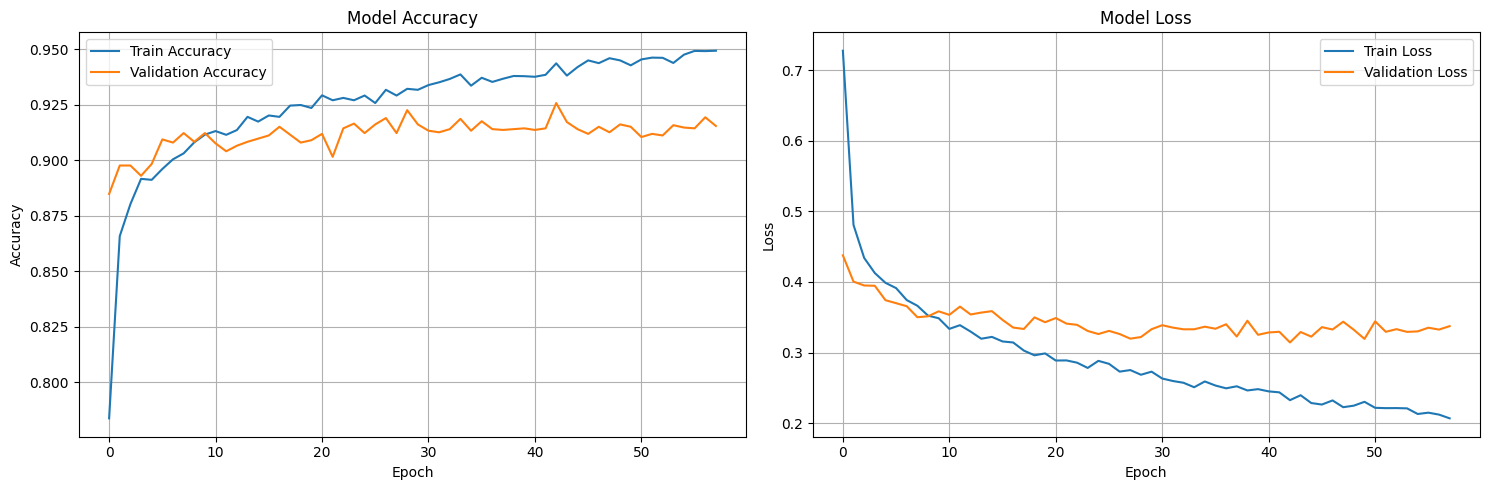

In [28]:
model_efficientnet,history_efficientnet = efficientnet(train_data,val_data,test_data,img_size=IMG_SIZE,num_classes=6)


Evaluating Train...
438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step

2024-12-16 03:34:37.928386: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294', 40 bytes spill stores, 40 bytes spill loads

2024-12-16 03:34:38.334885: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294_0', 8 bytes spill stores, 8 bytes spill loads

E0000 00:00:1734348883.174823  277130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734348883.379487  277130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734348883.573492  277130 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a 

439/439 ━━━━━━━━━━━━━━━━━━━━ 76s 152ms/step

Classification Report for Train Data:
              precision    recall  f1-score   support

   buildings       0.98      0.94      0.96      2191
      forest       0.99      0.99      0.99      2271
     glacier       0.90      0.93      0.91      2404
    mountain       0.93      0.91      0.92      2512
         sea       0.98      0.97      0.98      2274
      street       0.94      0.98      0.96      2382

    accuracy                           0.95     14034
   macro avg       0.96      0.95      0.95     14034
weighted avg       0.95      0.95      0.95     14034

Train Metrics:
  AUC: 0.9973
  Precision: 0.9540
  Recall: 0.9536
  F1-Score: 0.9536


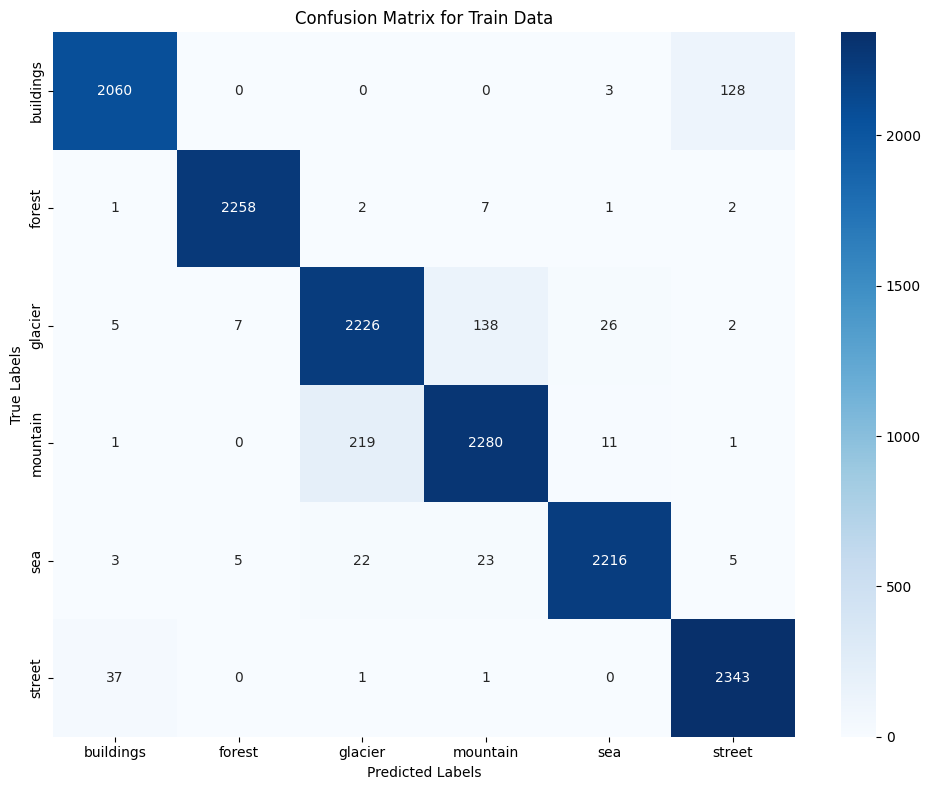


Evaluating Validation...
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step

2024-12-16 03:35:10.345315: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294', 40 bytes spill stores, 40 bytes spill loads

2024-12-16 03:35:10.457721: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294_0', 8 bytes spill stores, 8 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 25s 289ms/step

Classification Report for Validation Data:
              precision    recall  f1-score   support

   buildings       0.93      0.90      0.91       438
      forest       0.99      0.98      0.99       454
     glacier       0.87      0.84      0.85       480
    mountain       0.86      0.88      0.87       502
         sea       0.94      0.94      0.94       454
      street       0.91      0.95      0.93       476

    accuracy                           0.91      2804
   macro avg       0.92      0.92      0.92      2804
weighted avg       0.91      0.91      0.91      2804

Validation Metrics:
  AUC: 0.9920
  Precision: 0.9142
  Recall: 0.9141
  F1-Score: 0.9140


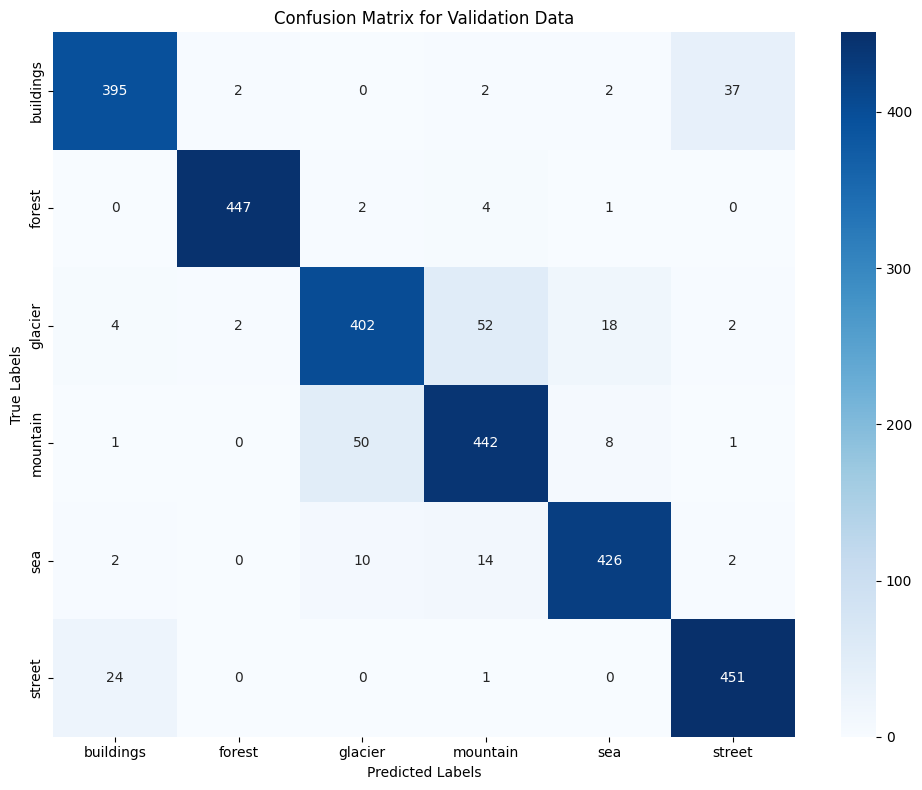


Evaluating Test...
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step

2024-12-16 03:35:45.393025: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294', 40 bytes spill stores, 40 bytes spill loads

2024-12-16 03:35:45.433428: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2294_0', 8 bytes spill stores, 8 bytes spill loads

E0000 00:00:1734348949.443614  277133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734348949.641784  277133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734348950.531843  277133 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a 

94/94 ━━━━━━━━━━━━━━━━━━━━ 40s 425ms/step

Classification Report for Test Data:
              precision    recall  f1-score   support

   buildings       0.94      0.90      0.92       437
      forest       0.99      0.99      0.99       474
     glacier       0.86      0.87      0.87       553
    mountain       0.88      0.85      0.87       525
         sea       0.95      0.96      0.96       510
      street       0.91      0.95      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000

Test Metrics:
  AUC: 0.9926
  Precision: 0.9203
  Recall: 0.9203
  F1-Score: 0.9201


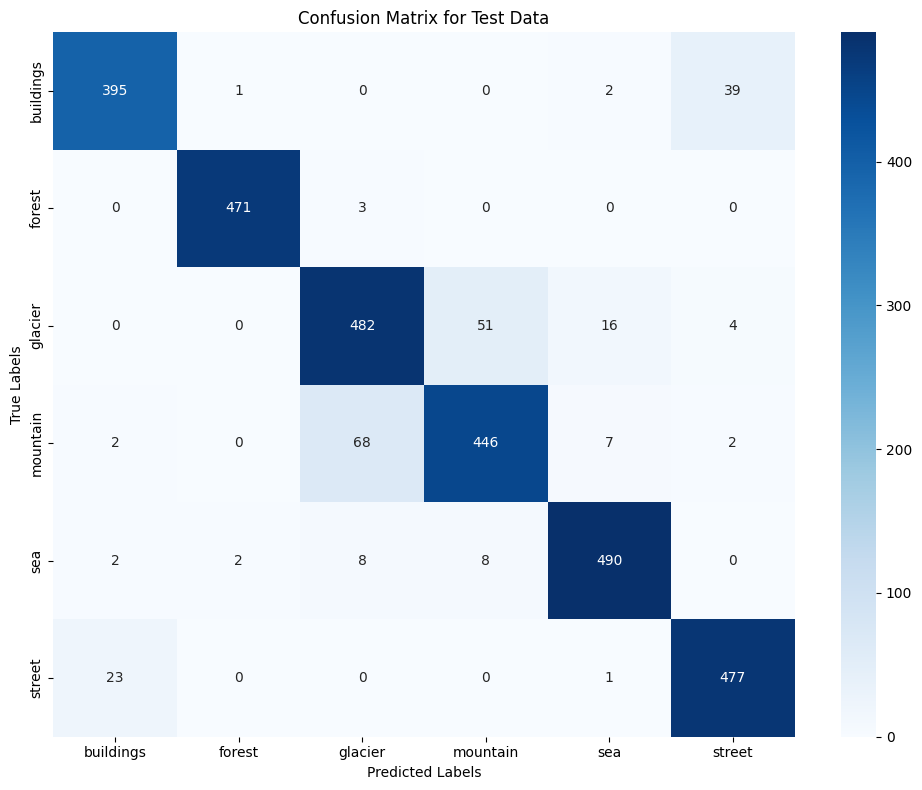

In [29]:
efficientnet_train = evaluate_model(train_eval, model_efficientnet, "Train")
efficientnet_val = evaluate_model(val_data, model_efficientnet, "Validation")
efficientnet_test = evaluate_model(test_data, model_efficientnet, "Test")
results["EfficientNetB0"] = efficientnet_test

E0000 00:00:1734348961.205496  277131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734348961.409728  277131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734348962.353697  277131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1734348962.589237  277131 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


[('..//dataset/seg_test/buildings/20733.jpg', 'buildings'),
 ('..//dataset/seg_test/mountain/23103.jpg', 'mountain'),
 ('..//dataset/seg_test/street/21800.jpg', 'street'),
 ('..//dataset/seg_test/glacier/21859.jpg', 'glacier'),
 ('..//dataset/seg_test/buildings/20966.jpg', 'buildings')]

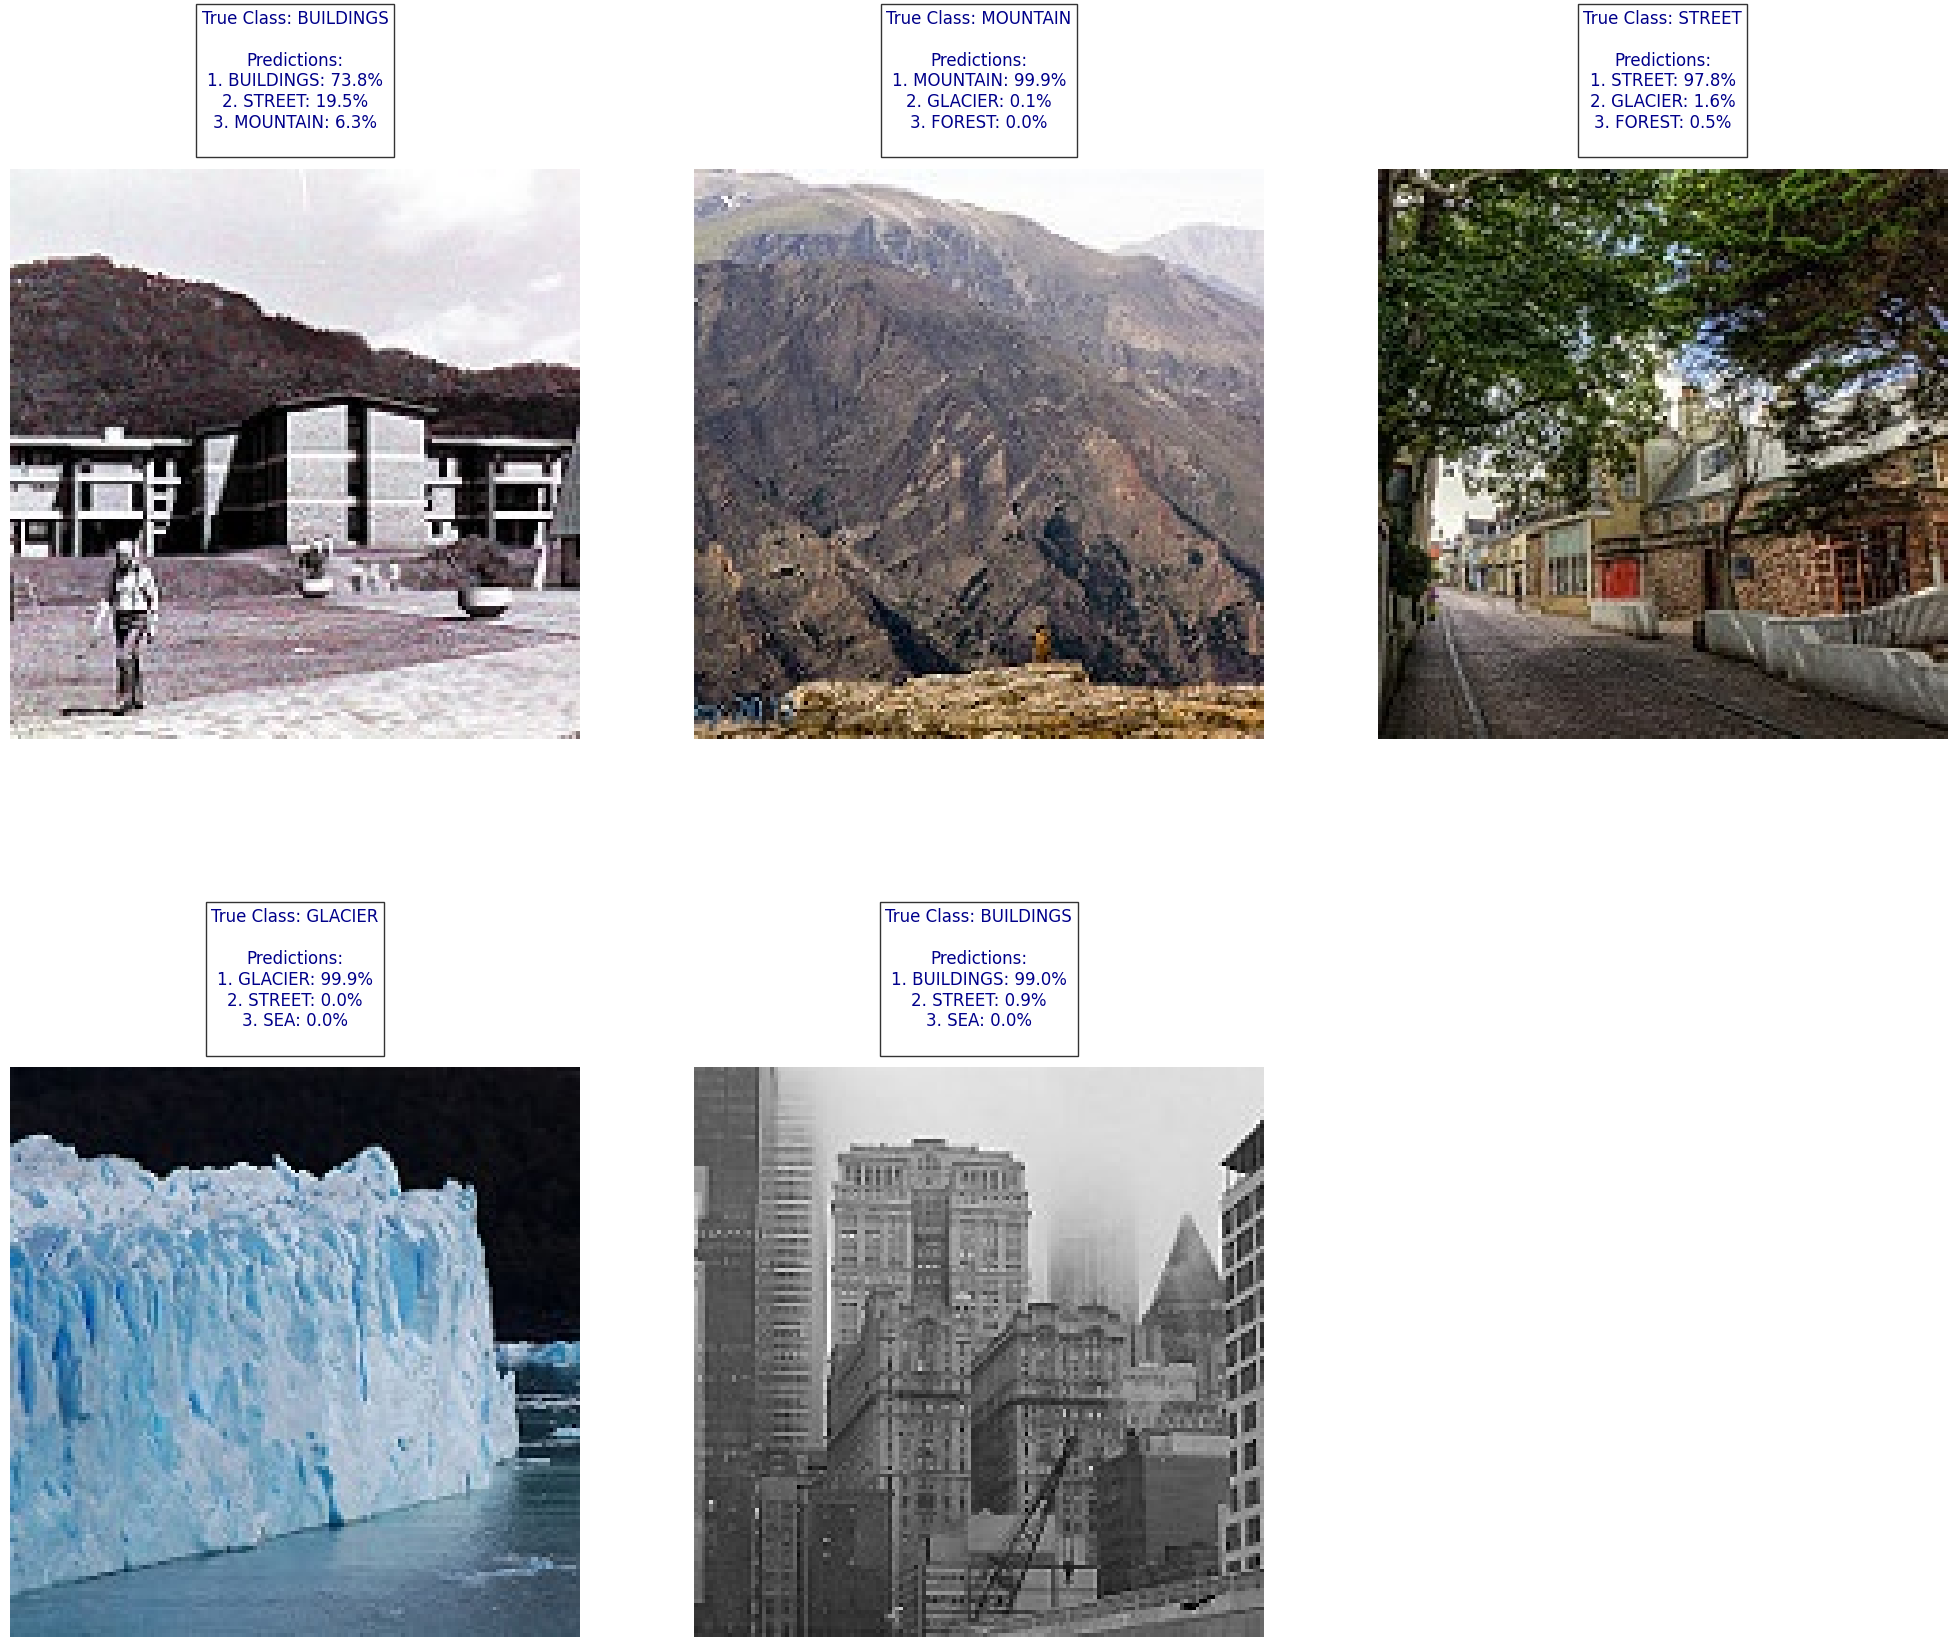

In [30]:
predict_random_images(model=model_efficientnet,test_dir=TEST_DIR,img_size=IMG_SIZE,class_indices=metadata['class_indices'],num_images=5)

In [31]:
clear_session()

<h3>VGG16</h3>

Found 14034 images belonging to 6 classes.
Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Data prepared for VGG16
Train data after image augmentation and preprocessing


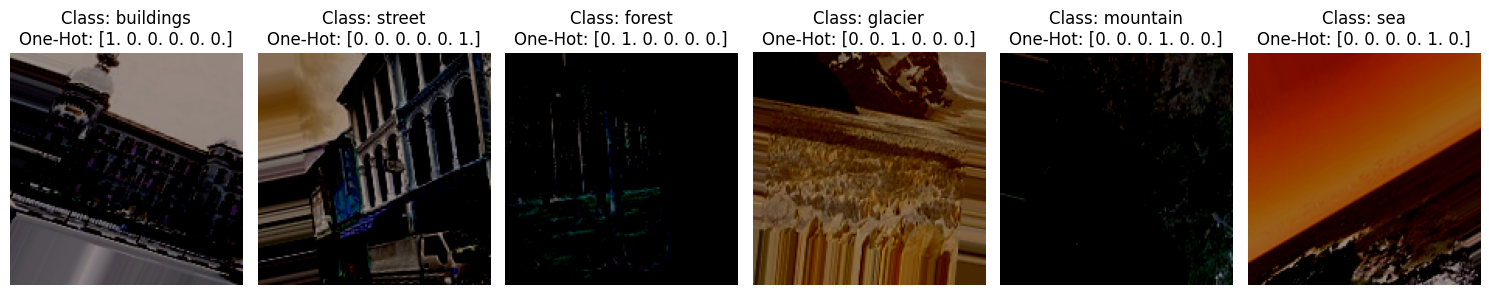

Test data after resizing and preprocessing


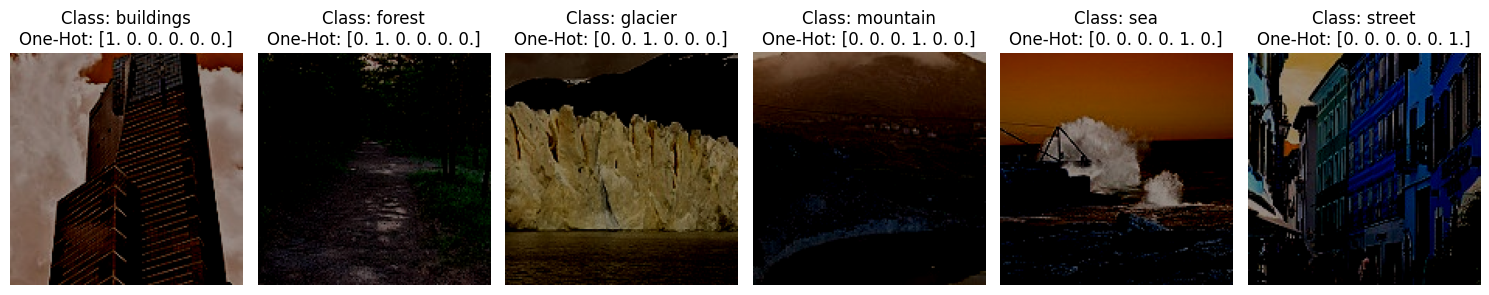

In [32]:
train_data,train_eval,val_data, test_data, metadata = create_augmented_data_generators(train_dir=TRAIN_DIR,test_dir=TEST_DIR,img_size=IMG_SIZE,batch_size=BATCH_SIZE
,model_type="VGG16")

In [33]:
def vgg16(train_data, val_data, test_data, img_size, num_classes, learning_rate=0.001, epochs=EPOCHS, batch_size=BATCH_SIZE, dropout_rate=0.2, checkpoint_path='vgg16_best.keras'):
    
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=img_size + (3,), pooling='avg')
    base_model.trainable = False
   
    inputs = base_model.input
    x = base_model.output
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0001), kernel_initializer='he_uniform', bias_initializer='zeros')(x)
    x = BatchNormalization(momentum=0.9, epsilon=1e-4)(x)
    x = Dropout(dropout_rate)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, mode='min'),
        ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-4, verbose=1, mode='min'),
        ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
    ]

    model.compile(optimizer=Adam(learning_rate=learning_rate, epsilon=1e-7, clipnorm=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Training the last fully connected layer...")

    history = model.fit(train_data, validation_data=val_data, epochs=epochs, callbacks=callbacks, batch_size=batch_size)

    print("\nPlotting Training Curves...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid()

    plt.tight_layout()
    plt.show()

    model.load_weights(checkpoint_path)

    return model, history

Training the last fully connected layer...
Epoch 1/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.7500 - loss: 0.8328
Epoch 1: val_accuracy improved from -inf to 0.86484, saving model to vgg16_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 117s 313ms/step - accuracy: 0.7502 - loss: 0.8323 - val_accuracy: 0.8648 - val_loss: 0.4891 - learning_rate: 0.0010
Epoch 2/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8570 - loss: 0.5152
Epoch 2: val_accuracy improved from 0.86484 to 0.86591, saving model to vgg16_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 297ms/step - accuracy: 0.8570 - loss: 0.5152 - val_accuracy: 0.8659 - val_loss: 0.4768 - learning_rate: 0.0010
Epoch 3/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8694 - loss: 0.4569
Epoch 3: val_accuracy improved from 0.86591 to 0.87981, saving model to vgg16_best.keras
351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 299ms/step - accuracy: 0.8694 - loss: 0.4569 - val_accuracy: 0.8798 - val_loss: 0.4668 - learning_rate: 0

351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9140 - loss: 0.2934
Epoch 23: val_accuracy did not improve from 0.90300
351/351 ━━━━━━━━━━━━━━━━━━━━ 105s 298ms/step - accuracy: 0.9140 - loss: 0.2934 - val_accuracy: 0.9016 - val_loss: 0.3875 - learning_rate: 5.0000e-04
Epoch 24/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.9143 - loss: 0.2972
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 24: val_accuracy did not improve from 0.90300
351/351 ━━━━━━━━━━━━━━━━━━━━ 102s 289ms/step - accuracy: 0.9143 - loss: 0.2972 - val_accuracy: 0.8980 - val_loss: 0.3696 - learning_rate: 5.0000e-04
Epoch 25/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.9127 - loss: 0.2847
Epoch 25: val_accuracy did not improve from 0.90300
351/351 ━━━━━━━━━━━━━━━━━━━━ 104s 297ms/step - accuracy: 0.9127 - loss: 0.2847 - val_accuracy: 0.8944 - val_loss: 0.3759 - learning_rate: 2.5000e-04
Epoch 26/70
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accurac

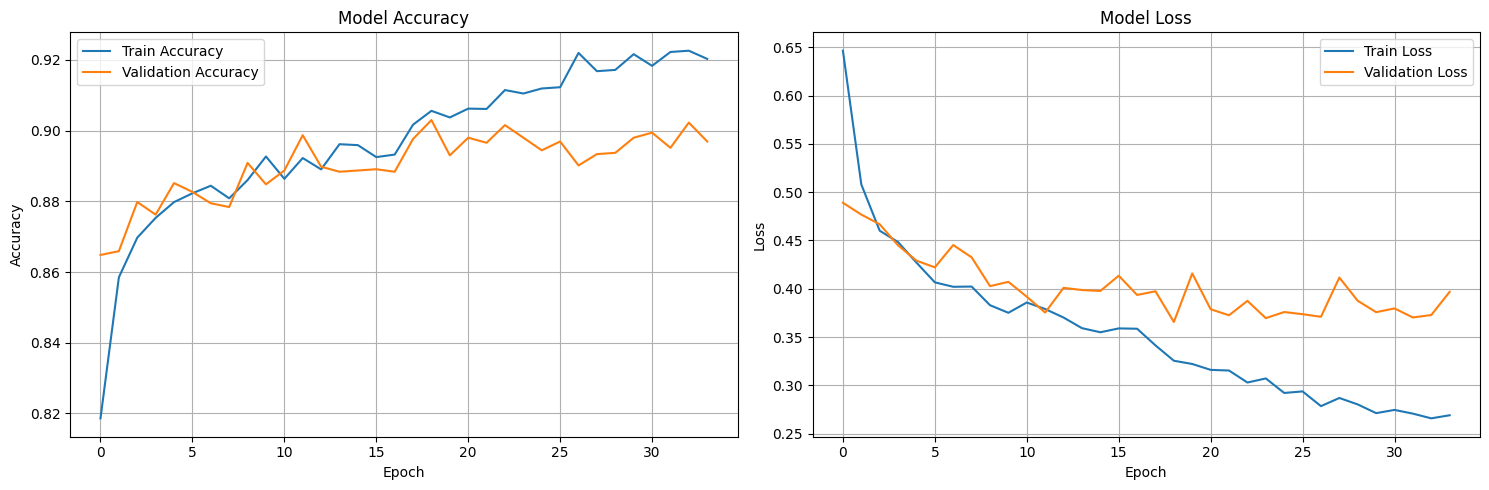

In [34]:
model_vgg16, history_vgg16 = vgg16(train_data,val_data,test_data,img_size=IMG_SIZE,num_classes=6)


Evaluating Train...


2024-12-16 04:35:50.543538: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_228', 12 bytes spill stores, 12 bytes spill loads



438/439 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

2024-12-16 04:36:46.649672: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_228', 12 bytes spill stores, 12 bytes spill loads



439/439 ━━━━━━━━━━━━━━━━━━━━ 60s 130ms/step

Classification Report for Train Data:
              precision    recall  f1-score   support

   buildings       0.92      0.94      0.93      2191
      forest       1.00      0.95      0.97      2271
     glacier       0.81      0.91      0.86      2404
    mountain       0.91      0.82      0.86      2512
         sea       0.96      0.96      0.96      2274
      street       0.94      0.94      0.94      2382

    accuracy                           0.92     14034
   macro avg       0.92      0.92      0.92     14034
weighted avg       0.92      0.92      0.92     14034

Train Metrics:
  AUC: 0.9892
  Precision: 0.9210
  Recall: 0.9185
  F1-Score: 0.9188


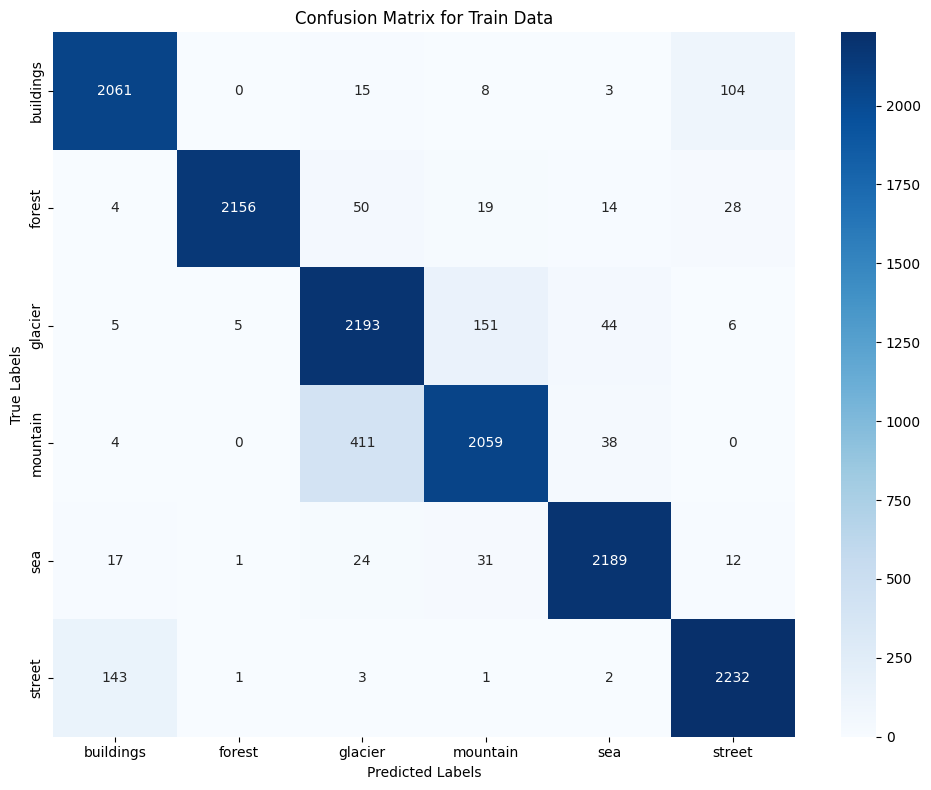


Evaluating Validation...
87/88 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step

2024-12-16 04:37:11.745064: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_228', 12 bytes spill stores, 12 bytes spill loads



88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 259ms/step

Classification Report for Validation Data:
              precision    recall  f1-score   support

   buildings       0.90      0.90      0.90       438
      forest       0.97      0.97      0.97       454
     glacier       0.81      0.86      0.84       480
    mountain       0.86      0.81      0.83       502
         sea       0.92      0.91      0.92       454
      street       0.89      0.91      0.90       476

    accuracy                           0.89      2804
   macro avg       0.89      0.89      0.89      2804
weighted avg       0.89      0.89      0.89      2804

Validation Metrics:
  AUC: 0.9870
  Precision: 0.8917
  Recall: 0.8912
  F1-Score: 0.8912


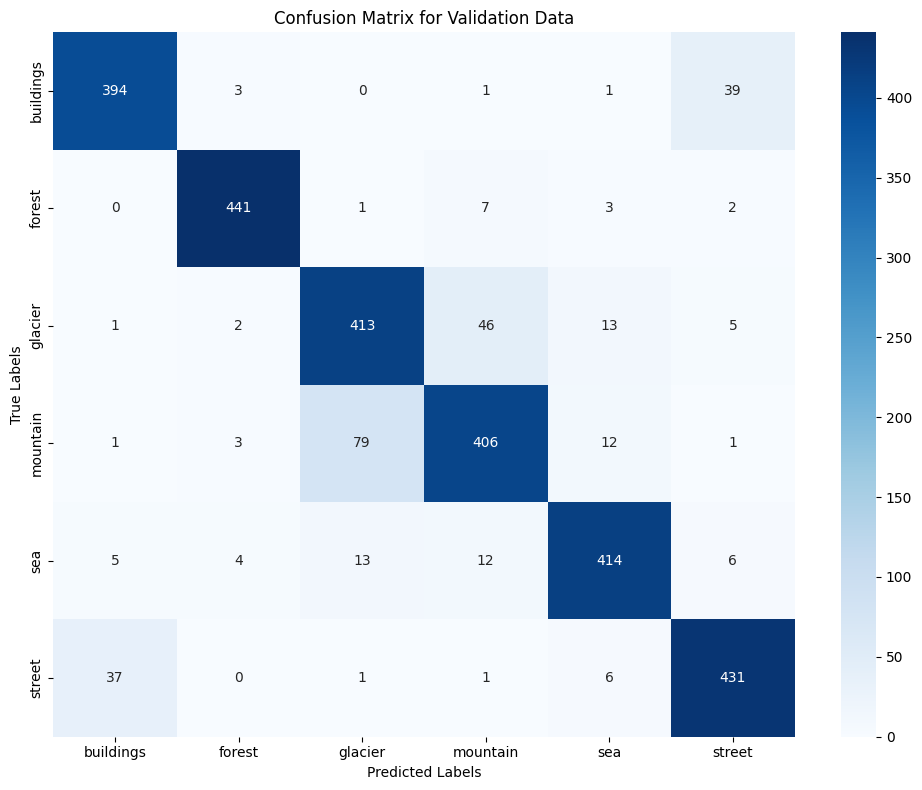


Evaluating Test...
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step

2024-12-16 04:37:25.762299: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_228', 12 bytes spill stores, 12 bytes spill loads



94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step

Classification Report for Test Data:
              precision    recall  f1-score   support

   buildings       0.88      0.91      0.89       437
      forest       0.99      0.93      0.96       474
     glacier       0.79      0.90      0.84       553
    mountain       0.89      0.78      0.83       525
         sea       0.94      0.95      0.94       510
      street       0.91      0.89      0.90       501

    accuracy                           0.89      3000
   macro avg       0.90      0.89      0.89      3000
weighted avg       0.90      0.89      0.89      3000

Test Metrics:
  AUC: 0.9855
  Precision: 0.8956
  Recall: 0.8920
  F1-Score: 0.8922


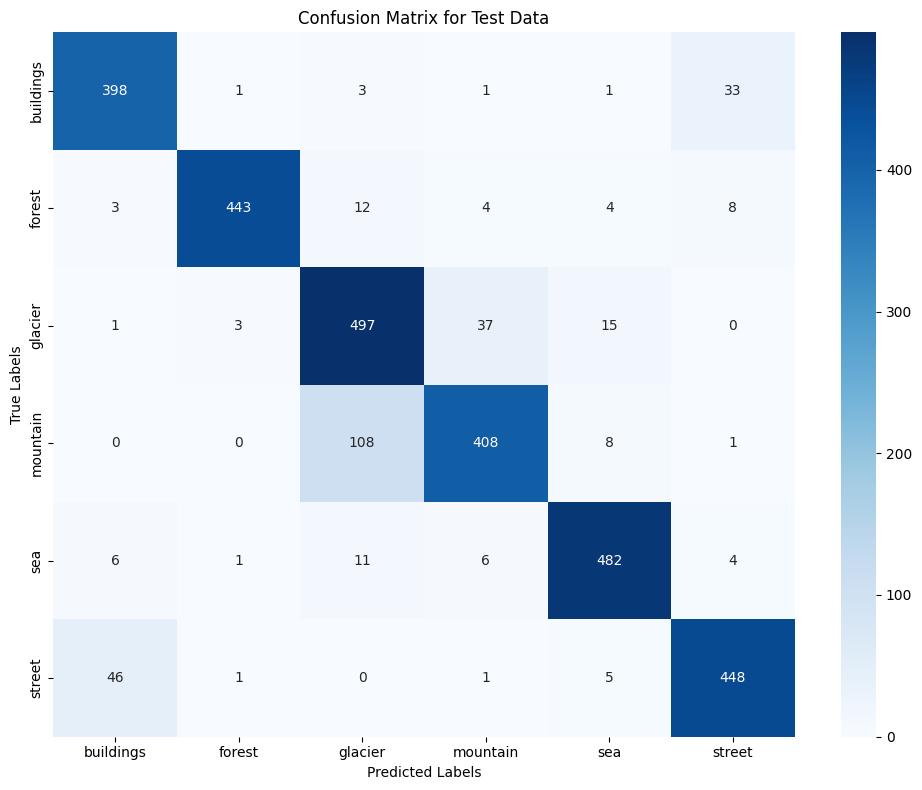

In [35]:
vgg16_train = evaluate_model(train_eval, model_vgg16, "Train")
vgg16_val = evaluate_model(val_data, model_vgg16, "Validation")
vgg16_test = evaluate_model(test_data, model_vgg16, "Test")
results["VGG16"] = vgg16_test

Model Predictions on Random Test Images by VGG16


[('..//dataset/seg_test/forest/22996.jpg', 'forest'),
 ('..//dataset/seg_test/forest/22201.jpg', 'forest'),
 ('..//dataset/seg_test/glacier/20275.jpg', 'glacier'),
 ('..//dataset/seg_test/sea/24158.jpg', 'sea'),
 ('..//dataset/seg_test/street/22597.jpg', 'street'),
 ('..//dataset/seg_test/street/23263.jpg', 'street')]

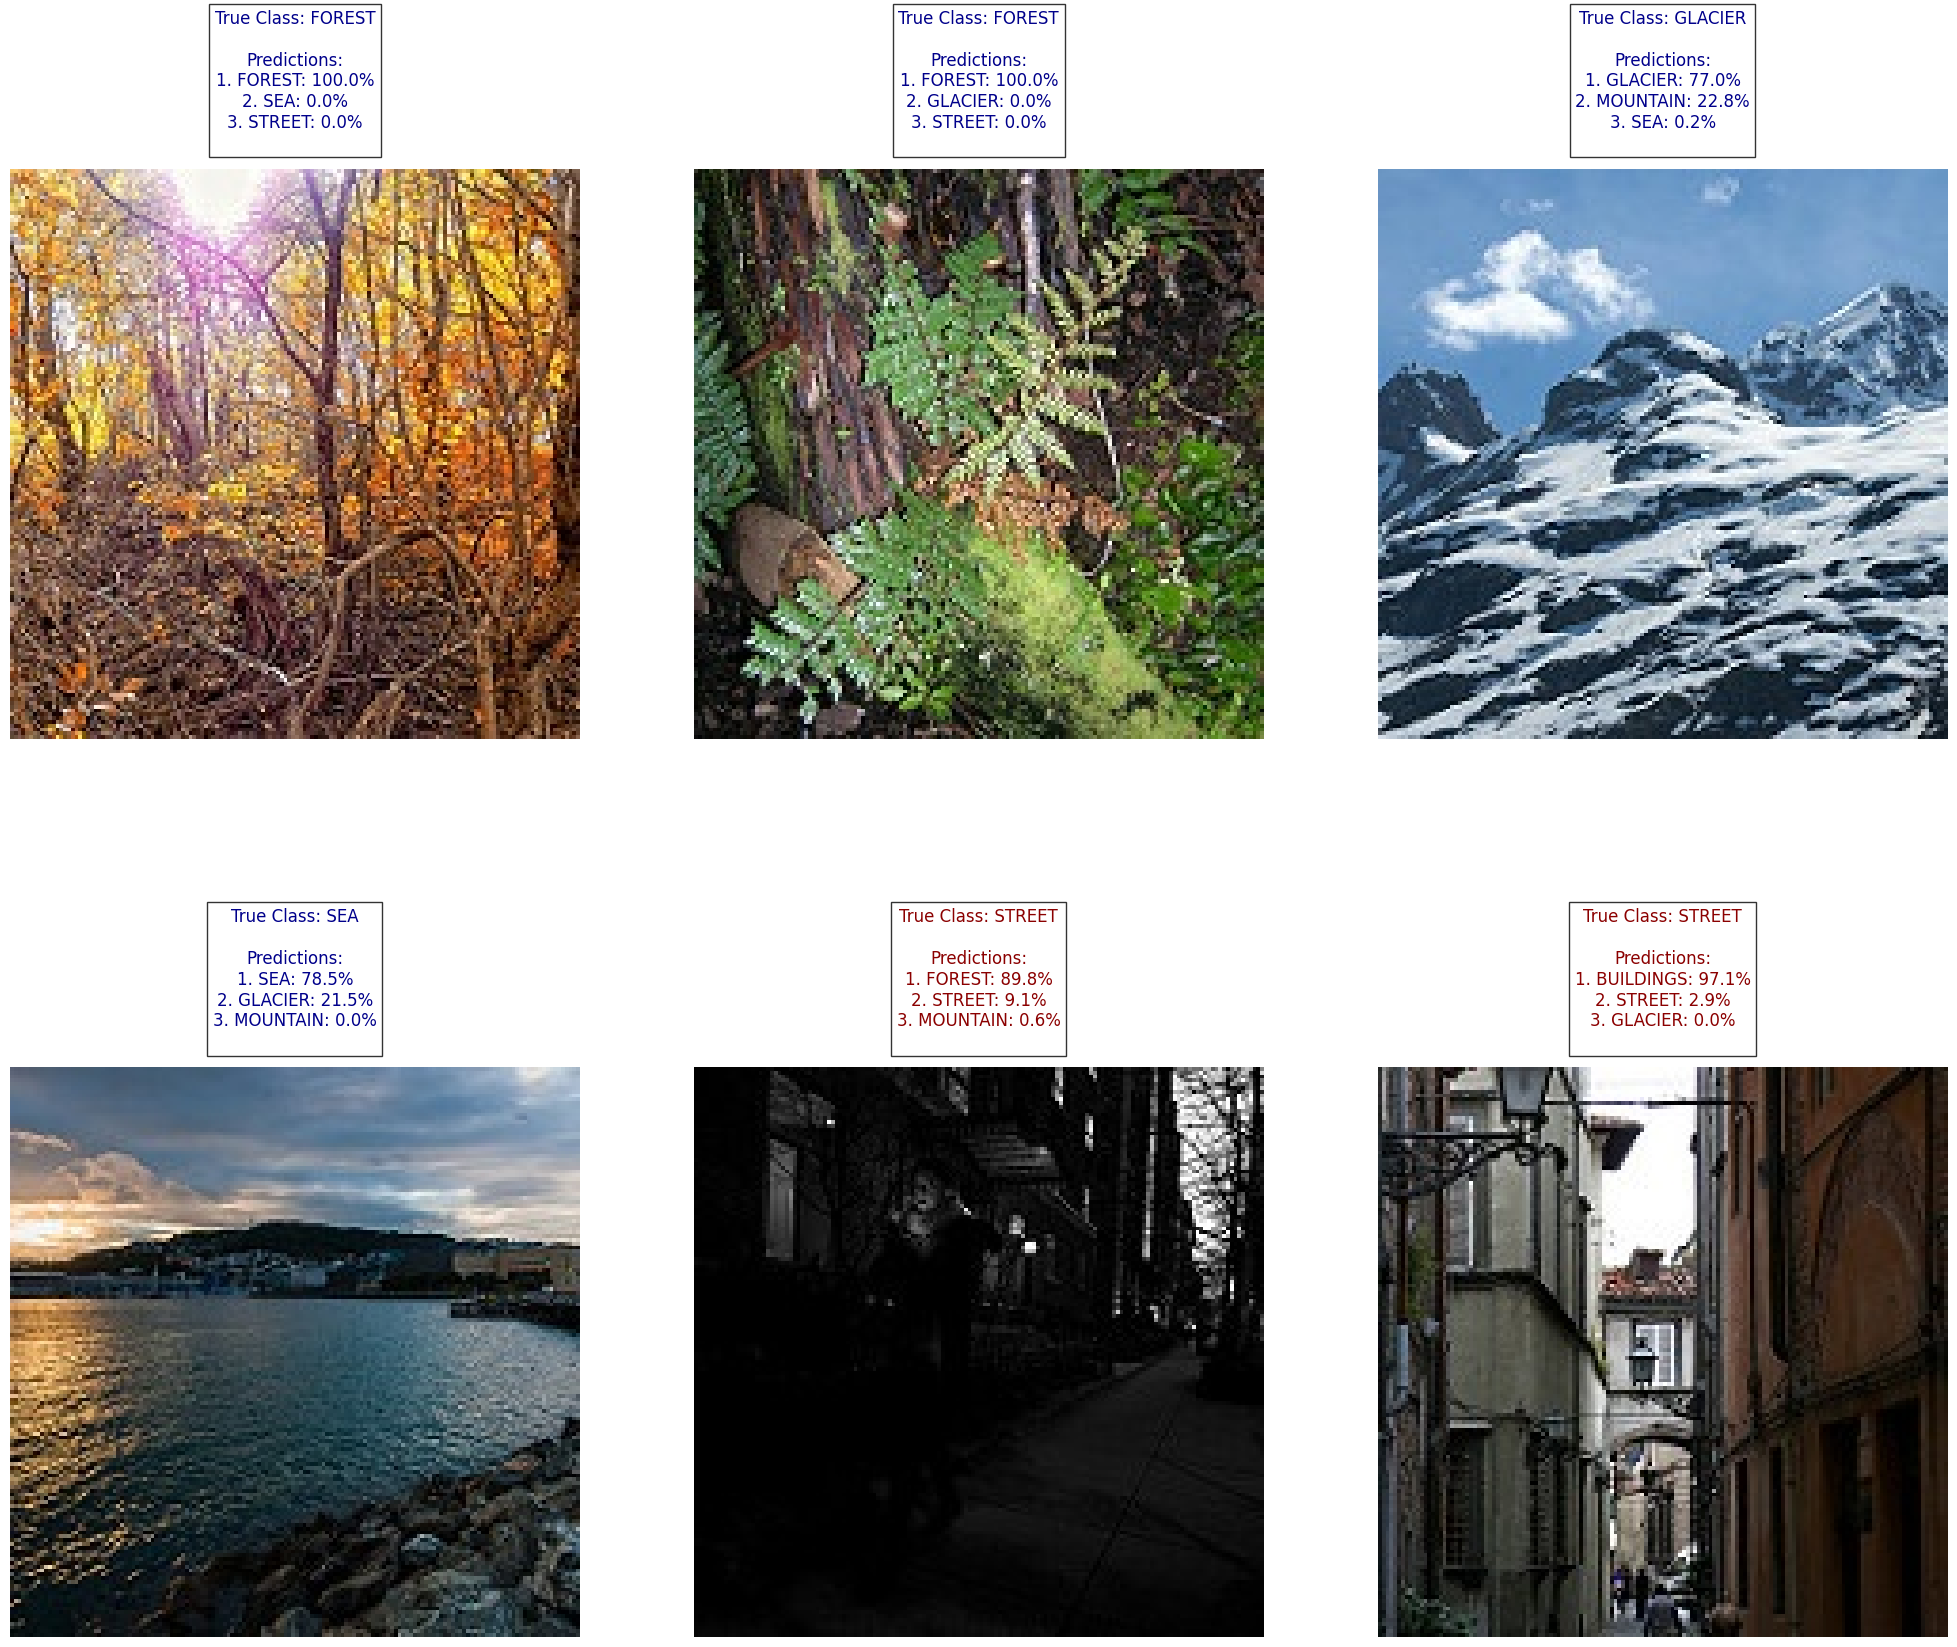

In [36]:
print("Model Predictions on Random Test Images by VGG16")
predict_random_images(model=model_vgg16,test_dir=TEST_DIR,img_size=IMG_SIZE,class_indices=metadata['class_indices'],num_images=6)

<h3> Model Comparisons </h3>

In [37]:
models_metrics = [resnet50_test,resnet101_test,efficientnet_test,vgg16_test]

In [40]:
def plot_model_comparison(models_metrics):
    metrics = ["Precision", "Recall", "F1-Score", "AUC"]
    model_names = list(results.keys())
    
    for metric in metrics:
        values = [results[model][metric] for model in model_names]
        
        plt.figure(figsize=(8, 5))
        plt.bar(model_names, values)
        plt.title(f"Model Comparison: {metric}")
        plt.xlabel("Models")
        plt.ylabel(metric)
        plt.ylim(0, 1)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

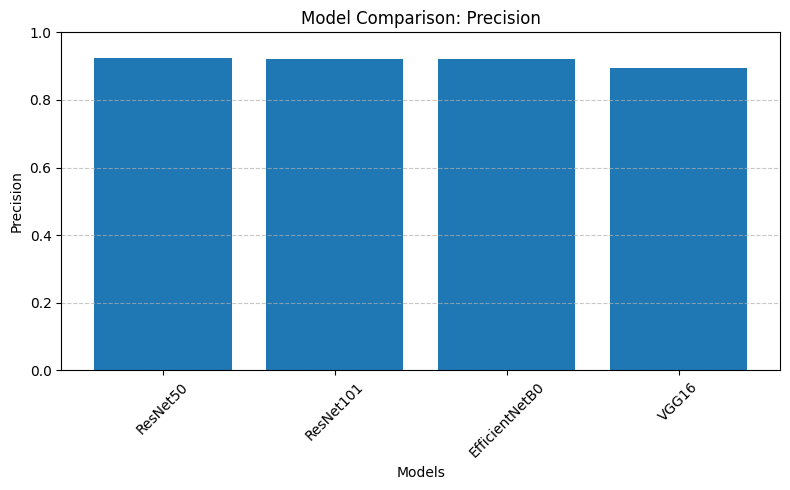

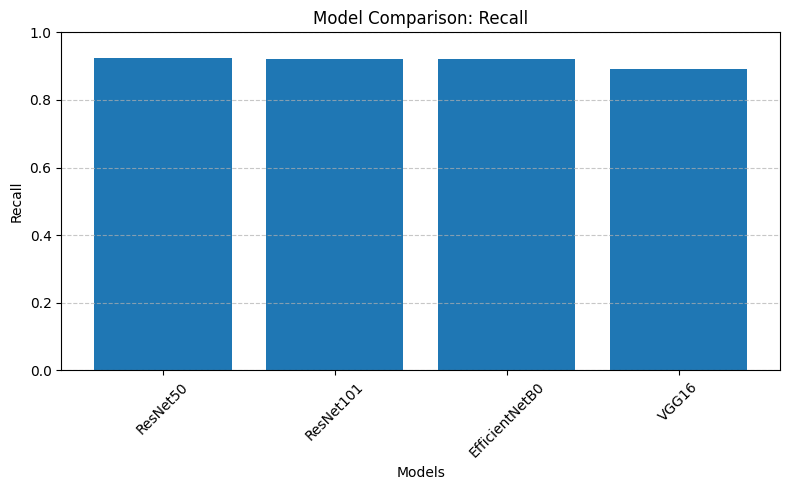

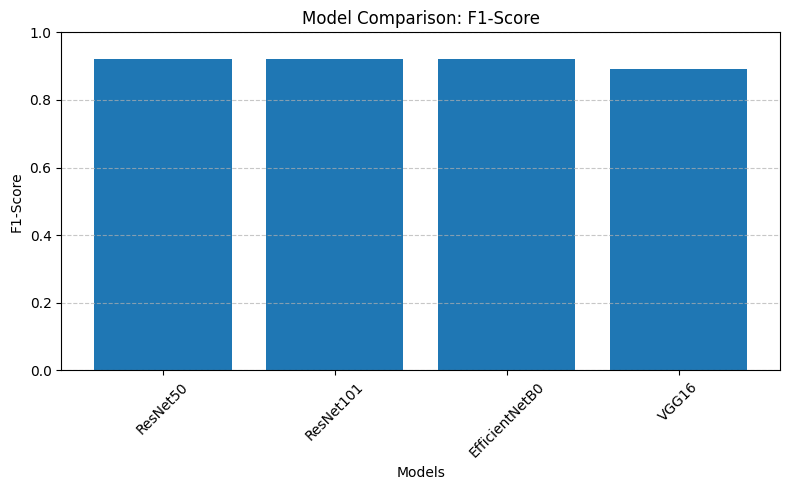

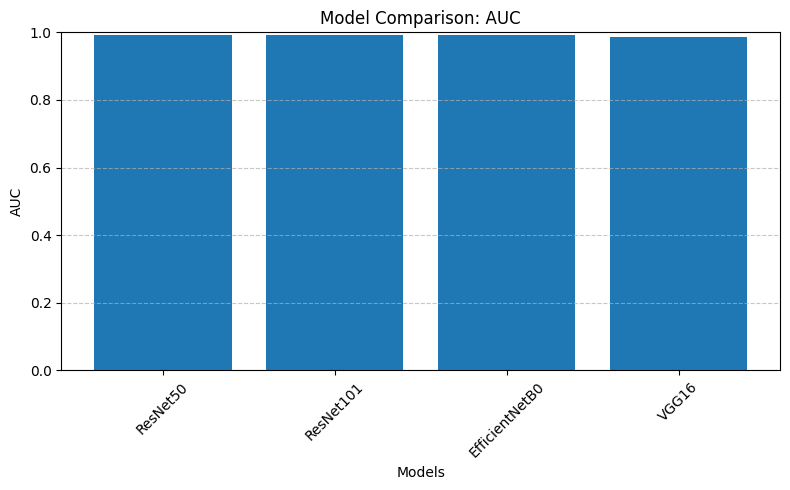

In [41]:
plot_model_comparison(results)

<h3> Conclusions</h3>

1. ResNet50 is the best-performing model overall, providing the highest balance of AUC, precision, recall, and F1-score.
2. ResNet101 offers marginal improvements for some classes but is computationally more expensive, have comparable performance with ResNet50.
3. EfficientNetB0 is nearly as good as ResNet50 but with much lower computational cost,( takes lesser epochs to reach similar accuracy).
4. VGG16 underperforms and struggles with overlapping classes (eg: mountain and glacier).

<h3>References</h3>

1. https://keras.io/api/applications/vgg/#vgg16-function
2. https://keras.io/api/applications/efficientnet/
3. https://keras.io/api/applications/resnet/
4. https://drlee.io/multiclass-classification-with-tensorflow-a-step-by-step-guide-using-the-iris-dataset-79045c870b86
5. https://scikit-learn.org/1.5/modules/model_evaluation.html
6. https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
7. https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
8. https://seaborn.pydata.org/generated/seaborn.heatmap.html

9. GPT references

<b>Ques - How can I suppress TensorFlow logs and configure GPU memory growth to prevent GPU memory from being fully pre-allocated?</b><br>
Generated Response -<br> 

```
1. Suppressing unnecessary TensorFlow logs and warnings.
2. Dynamically configuring TensorFlow GPU memory allocation for efficient usage.

import os
import logging
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_gpu_strict_conv_algorithm_picker=false'
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
logging.getLogger("tensorflow").setLevel(logging.ERROR)
```

<b>Ques - How to check if tensorflow is utilizing device GPU?</b> <br>
Generated Code - <br>
```
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

!nvidia-smi --query-gpu=name --format=csv #if Nvidia GPU on device

```
<b> Ques - give a sample code to extract images from root directory for predictions</b><br>
Sample response - <br>

```
if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                if img.endswith('Replace you img extension here'): #.jpg,.jpeg,.png etc.
                    image_paths.append((os.path.join(class_path, img), class_dir))
```
